In [2]:
import os
import time
import random
import collections
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# from albumentations import HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
# from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


import warnings
warnings.filterwarnings("ignore")
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA avaliable: {torch.cuda.is_available()}')

PyTorch version: 2.0.0
CUDA avaliable: True


In [3]:
class CellDataset(Dataset):
    def __init__(self, df, train_path, transforms=None):
        super().__init__()
        self.df = df                    # df_train
        self.train_path = train_path
        self.transforms = transforms
        self.img_info = collections.defaultdict(dict)
        
        ## Encoding cell_type by dict
        ## result: {'shsy5y': 1, 'astro': 2, 'cort': 3}
        cell_type_dict = dict.fromkeys(df_train.cell_type.unique())  # {'shsy5y': None, 'astro': None, 'cort': None}
        v = 0
        for k in cell_type_dict.keys():
            v += 1
            cell_type_dict[k] = v
        
        ## 同一个 id 的所有 annotation 汇总成一个 list，并保留对应的 cell type 信息。
        df_info = df.groupby("id").agg({"annotation": lambda x: list(x),
                                        "cell_type": "first"}) \
                                  .reset_index()
        for idx, row in df_info.iterrows():
            self.img_info[idx] = {'image_id': row['id'],
                                  'image_path': os.path.join(self.train_path, row['id'] + '.png'),
                                  'annotations': row["annotation"],
                                  'cell_type' : cell_type_dict[row['cell_type']]}
    
    
    
    def get_box(self, instance_mask):
        """Get the bounding box of a given mask of an instance in an image"""
        pos = np.where(instance_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        
        return [xmin, ymin, xmax, ymax]
    
    
    
    def __getitem__(self, idx):
        """Get the image and target"""        
        info = self.img_info[idx]
        img_path = info["image_path"]
        img = Image.open(img_path).convert("RGB")    # L mode -> RGB mode, also: 1 channel -> 3 channels
        n_instances = len(info["annotations"])
        
        masks = np.zeros((n_instances, HEIGHT, WIDTH), dtype=np.uint8)
        boxes = []        
        for i, annotation in enumerate(info["annotations"]):
            msk = rle_decode(annotation, (HEIGHT, WIDTH))            
            # msk = Image.fromarray(msk)
            # if self.should_resize:
            #     msk = msk.resize((self.width, self.height), resample=Image.BILINEAR)
            # msk = np.array(msk) > 0            
            masks[i, :, :] = msk
            boxes.append(self.get_box(msk))
        
        # dummy labels
        labels = [info["cell_type"] for _ in range(n_instances)]
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])    # area of each box
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.int8)
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((n_instances,), dtype=torch.int64)
        
        # The required target for the Mask R-CNN
        target = {"boxes": boxes,
                  'labels': labels,
                  'masks': masks,
                  'image_id': image_id,
                  'area': area,
                  'iscrowd': iscrowd}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
    
    
    
    def __len__(self):
        return len(self.img_info)

In [4]:
# Directory setting
DATA_DIR = '/kaggle/input/sartorius-cell-instance-segmentation/'

TRAIN_CSV = DATA_DIR + 'train.csv'
TRAIN_PATH = DATA_DIR + 'train/'
TEST_PATH = DATA_DIR + 'test/'

NORMALIZE = False                         # Normalize to resnet mean and std if True. Be set in transforms().
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)
IMG_SIZE = (224, 224)                     # size of resized image for model input
HEIGHT = 520                              # height of the provided train image
WIDTH = 704                               # width of the provided train image

H_LAYER = 256
BOX_DETECTIONS_PER_IMG = 790
MIN_SCORE = 0.59
MASK_THRESHOLD = 0.5   # Changes the confidence required for a pixel to be kept for a mask. Only used 0.5 till now.


BATCH_SIZE = 2
BATCH_SHUFFLE = True
EPOCHS = 18

USE_SCHEDULER = False  # Use a StepLR scheduler if True. Not tried yet.
MOMENTUM = 0.95
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# CELL_TYPES  = {0: 'shsy5y', 1: 'astro', 2: 'cort'}
CLASSES_NUM = 4        # 3 types of cell + 1 type as background
FOLDS = 3              # Kfold cross-validation


## Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {DEVICE} device')

Using cuda device


In [23]:
# These are slight redefinitions of torch.transformation classes
# The difference is that they handle the target and the mask
# Copied from Abishek, added new ones

class Compose():
    def __init__(self, transforms):
        self.transforms = transforms
    
    
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        
        return image, target

    
    

class VerticalFlip():
    def __init__(self, prob):
        self.prob = prob
    
    
    def __call__(self, image, target):
        if random.random() < self.prob:                  # 实现 VerticalFlip 的概率小于初始化的 prob
            height, weight = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]   # 因为 image.flip(-2) 将图片 vertical flip 了，所以相应的 bbox 的范围要做这番调整。
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target
    

class HorizontalFlip():
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:                # 实现 VerticalFlip 的概率小于初始化的 prob
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]  # 因为 image.flip(-1) 将图片 horizontal flip 了，所以相应的 bbox 的范围要做这番调整。
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target



class Normalize():
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target



class ToTensor():
    def __call__(self, image, target):
        # Convert the PIL image to a numpy array
        image = np.array(image)

        # Convert the numpy array to a PyTorch tensor
        image_tensor = torch.tensor(image).permute(2, 0, 1).float() / 255.0  
        # Move the tensor to the GPU
        image_tensor = image_tensor.cuda()
        #image = torch.tensor(image)
        return image_tensor, target
class Resize():
    def __call__(self, image, target):
        image = F.resize(image, IMG_SIZE)
        return image, target

In [24]:
def transforms(train=True):
    # transforms = [ToTensor(), Resize()]
    transforms = [ToTensor()]
    
    if NORMALIZE:        # Set to False in Configurations, cause it can be achieved in params of MRcnn.
        transforms.append(Normalize())
    
    # Data augmentation for training
    if train: 
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

In [25]:
def show_gpu_memory(device):
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 / 1024:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_cached(device) / 1024 / 1024:.2f} MB") 

show_gpu_memory(DEVICE)

Allocated GPU memory: 136.23 MB
Cached GPU memory: 500.00 MB


In [26]:
torch.cuda.get_device_properties(DEVICE)

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)

In [27]:
def build_image_mask(img, rle_list):
    """Decode RLEs (annotations) of all cell instance in an image into one mask image.
    
    Args:
        img (np.ndarray): image with single channel or multiple channels.
        rle_list (list of str): rles of all cell instances in an image as a list.
    
    Returns:
        np.ndarray: 1 - mask, 0 - background.
    """
    img_shape = img.shape
    h = img_shape[0]
    w = img_shape[1]
    
    mask = np.zeros((h, w))
    for rle in rle_list:
        mask += rle_decode(rle, (h, w))
    mask = mask.clip(0,1)
    
    return mask

In [28]:
df_train = pd.read_csv(TRAIN_CSV)
df_train.head().append(df_train.tail())

id                                         annotation  width  \
0      0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1      0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2      0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3      0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4      0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   
73580  ffdb3cc02eef  3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...    704   
73581  ffdb3cc02eef  341585 2 342287 5 342988 10 343690 13 344394 1...    704   
73582  ffdb3cc02eef  47788 3 48490 7 49192 11 49896 13 50599 14 513...    704   
73583  ffdb3cc02eef  333290 1 333993 2 334696 4 335399 5 336102 6 3...    704   
73584  ffdb3cc02eef  249775 2 250477 6 251180 8 251882 11 252585 12...    704   

       height cell_type plate_time sample_date  \
0         520    shsy5y  11h30m00s  2019-06-16   
1         520    shsy5y  11h30m00s  2019-06-16   
2         520    shsy5y  11h30m00s  2019-06-16   
3         520    shsy5y  11h30m00s  2019-06-16   
4         520    shsy5y  11h30m00s  2019-06-16   
73580     520      cort  11h59m00s  2020-11-01   
73581     520      cort  11h59m00s  2020-11-01   
73582     520      cort  11h59m00s  2020-11-01   
73583     520      cort  11h59m00s  2020-11-01   
73584     520      cort  11h59m00s  2020-11-01   

                                sample_id elapsed_timedelta  
0      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
73580   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73581   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73582   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73583   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00  
73584   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00

In [29]:
def rle_decode(rle, img_shape, color=1):
    """Decode the RLE (annotation) of an particular cell instance in an image to its correspongding mask.

    Args:
        rle (str): mask with run length encoding.
        img_shape ((int, int)): (height, width) of the image, also the shape of mask np.ndarray to return.
        color (int): brightness of the mask pixel. Default to 1.

    Returns:
        np.ndarray: 1 - mask, 0 - background.
    """
    rle_list = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_list[0:][::2], rle_list[1:][::2])]
    starts -= 1
    ends = starts + lengths
    
    mask = np.zeros(img_shape[0] * img_shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = color
    
    return mask.reshape(img_shape)

In [30]:
# train.csv 中 id 列是图片编号，每一行的 annotation 都是该图片中的一个细胞实例的 mask 数据。
# 若一张图片中有 395 个细胞实例的 mask，则这张图片会在表格中出现 395 行。
df_instances = df_train.groupby(['id']).agg({'annotation': 'count', 'cell_type': 'first'})
df_instances.head()

annotation cell_type
id                                
0030fd0e6378         395    shsy5y
0140b3c8f445         108     astro
01ae5a43a2ab          36      cort
026b3c2c4b32          42      cort
029e5b3b89c7          34      cort

In [31]:
# 每一种细胞类型（一张图片只有一种细胞）它在一张图片中 instance segmentation mask
# (亦即表中对应图片的 annotation 行数) 的总数的分布的分位数情况。
df_instances_pentiles = df_train.groupby(['id']).agg({'annotation': 'count', 'cell_type': 'first'})
df_instances_pentiles = df_instances_pentiles.groupby("cell_type")[['annotation']]\
                                             .describe(percentiles=[0.1, 0.25, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]).astype(int)\
                                             .T.droplevel(level=0).T.drop(['count', '50%', 'std'], axis=1)
df_instances_pentiles

mean  min  10%  25%  75%  80%  85%  90%  95%  99%  max
cell_type                                                        
astro        80    5   28   50  100  105  123  135  150  297  594
cort         33    4   18   23   39   43   46   54   70   93  108
shsy5y      337   49  143  235  429  447  508  539  559  739  790

In [32]:
img_shapes = set()
img_exts = set()
img_paths = Path(TRAIN_PATH).glob("*")

bar = tqdm(img_paths, total=df_train.id.unique().shape[0])    # should not be: total=len(list(img_paths))

for img_path in bar:
    img_bgr = cv2.imread(img_path.as_posix())                 # BGR mode
    img_rgb = img_bgr[:, :, ::-1]                             # RGB mode
    
    img_shapes.add(img_rgb.shape)
    img_exts.add(img_path.suffix)
print(f'Image shapes are {img_shapes}.')
print(f'Image extensions are {img_exts}.')

  0%|          | 0/606 [00:00<?, ?it/s]

Image shapes are {(520, 704, 3)}.
Image extensions are {'.png'}.


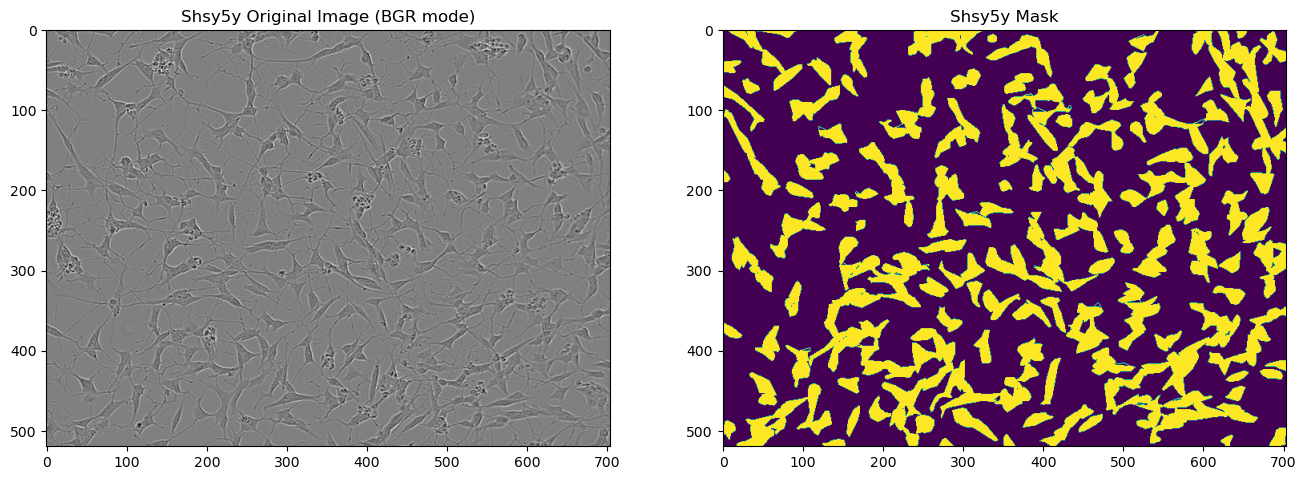

In [33]:
plt.figure(figsize=(16, 8))
img_id = "0030fd0e6378"
img = cv2.imread(TRAIN_PATH + img_id + ".png")         # BGR mode
ax1 = plt.subplot(121)
ax1.imshow(img)
ax1.set_title("Shsy5y Original Image (BGR mode)")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
ax2 = plt.subplot(122)
ax2.imshow(mask)
ax2.set_title("Shsy5y Mask")

plt.show()

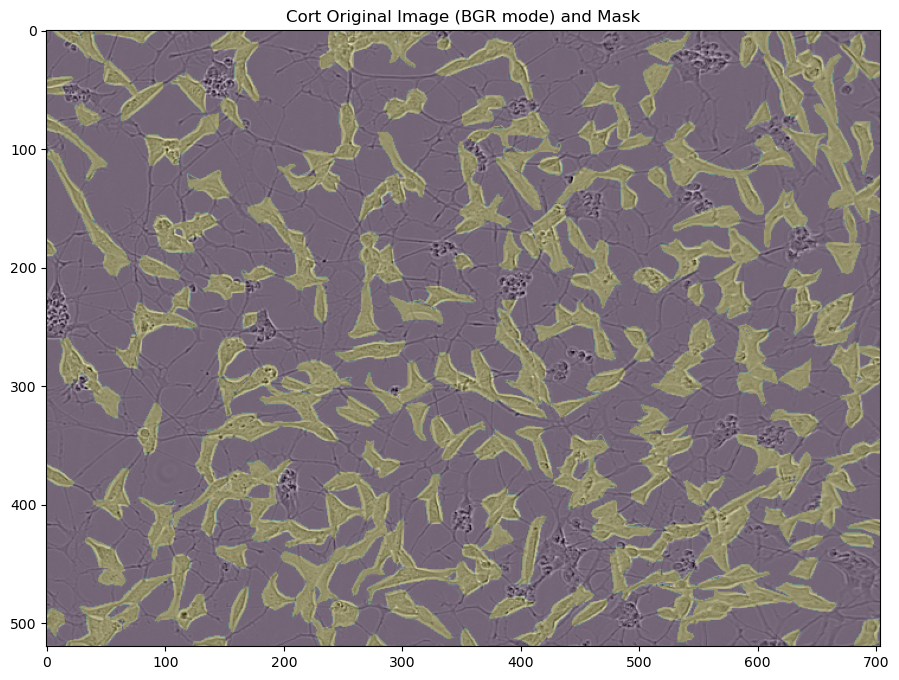

In [34]:
plt.figure(figsize=(16, 8))
img_id = "0030fd0e6378"
img = cv2.imread(TRAIN_PATH + img_id + ".png")          # BGR mode
plt.imshow(img)
plt.title("Cort Original Image (BGR mode) and Mask")

mask = build_image_mask(img, df_train[df_train.id == img_id].annotation.tolist())
plt.imshow(mask, alpha=0.2)

plt.show()

In [35]:
dataset_train = CellDataset(df=df_train, train_path=TRAIN_PATH, transforms=transforms(train=True))

dataloder_train = DataLoader(dataset_train, 
                             batch_size=BATCH_SIZE, 
                             shuffle=BATCH_SHUFFLE, 
                             # num_workers=2, 
                             collate_fn=lambda x: tuple(zip(*x))
                             )

In [36]:
from IPython.display import clear_output
!pip install timm
clear_output(wait=False)

In [37]:
from torchvision.models.detection import MaskRCNN, FasterRCNN
import torch
import timm
import torchvision
import torchvision.models as models
import torchvision.models.detection.backbone_utils as backbone_utils
from collections import OrderedDict
from torch import nn
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone


class TimmToVisionFPN(nn.Module):
    def __init__(self, backbone):
        super(TimmToVisionFPN, self).__init__()
        self.backbone = backbone
        self.out_channels = 256
        ## if you set timm model = resnet rather than cspresnet, you should set
        ## in_channels_list = [256, 512, 1024, 2048]
        self.in_channels_list = [128, 256, 512, 1024]
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=self.in_channels_list,
            out_channels=self.out_channels,
            extra_blocks=LastLevelMaxPool(),
        )

    def forward(self, x):
        x = self.backbone(x)
        out = OrderedDict()
        for i in range(len(x)-1):
            out[str(i)] = x[i+1]
        out = self.fpn(out)
        return out


class TimmToVision(nn.Module):
    def __init__(self, backbone, out_channels):
        super(TimmToVision, self).__init__()
        self.backbone = backbone
        self.out_channels = out_channels

    def forward(self, x):
        x = self.backbone(x)
        return x


def resnet50_fpn():
    backbone = backbone_utils.resnet_fpn_backbone('resnet50', True)
    return backbone


def calculate_param(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    return pytorch_total_params

from torchvision.models.detection import MaskRCNN, FasterRCNN
import torch
import timm
import torchvision
import torchvision.models as models
import torchvision.models.detection.backbone_utils as backbone_utils
from collections import OrderedDict
from torch import nn
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone


class TimmToVisionFPN(nn.Module):
    def __init__(self, backbone):
        super(TimmToVisionFPN, self).__init__()
        self.backbone = backbone
        self.out_channels = 256
        ## if you set timm model = resnet rather than cspresnet, you should set
        ## in_channels_list = [256, 512, 1024, 2048]
        self.in_channels_list = [128, 256, 512, 1024]
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=self.in_channels_list,
            out_channels=self.out_channels,
            extra_blocks=LastLevelMaxPool(),
        )

    def forward(self, x):
        x = self.backbone(x)
        out = OrderedDict()
        for i in range(len(x)-1):
            out[str(i)] = x[i+1]
        out = self.fpn(out)
        return out


class TimmToVision(nn.Module):
    def __init__(self, backbone, out_channels):
        super(TimmToVision, self).__init__()
        self.backbone = backbone
        self.out_channels = out_channels

    def forward(self, x):
        x = self.backbone(x)
        return x


def resnet50_fpn():
    backbone = backbone_utils.resnet_fpn_backbone('resnet50', True)
    return backbone


def calculate_param(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    return pytorch_total_params
































import torch
from torch import nn
from torch.nn import functional as F
from timm.models.cspnet import CrossStage


class ListModule(nn.Module):
    def __init__(self, *args):
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)


class FPNFFConv(nn.Module):
    def __init__(self, in_channels):
        super(FPNFFConv, self).__init__()

        inter_channels = in_channels // 4
        out_channels = in_channels

        self.relu = nn.ReLU(inplace=True)
        # top
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, inter_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = x
        # bottom
        out = self.bottleneck(x)
        # residual
        out1 = out + identity
        out1 = self.relu(out1)

        return out1


# group non local
class _NonLocalBlockND_Group(nn.Module):
    def __init__(self, in_channels, num_group, inter_channels=None, dimension=3, sub_sample=True, bn_layer=True,
                 relu_layer=True, use_softmax=True, use_ffconv=True, use_attention=True):
        super(_NonLocalBlockND_Group, self).__init__()

        assert dimension in [1, 2, 3]
        assert dimension == 2
        assert num_group in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels
        self.num_group = num_group

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        # inner channels are divided by num of groups
        conv_nd = nn.Conv2d
        max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
        bn = nn.BatchNorm2d

        self.relu_layer = relu_layer
        self.relu = nn.ReLU(inplace=True)

        self.use_softmax = use_softmax

        self.use_ffconv = use_ffconv
        self.use_attention = use_attention

        if self.use_softmax:
            self.softmax = nn.Softmax(dim=2)

        assert self.num_group <= self.inter_channels

        if self.use_attention:
            self.inter_channels_group = self.inter_channels // self.num_group
            # print (self.inter_channels_group)

            self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)

            self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                                 kernel_size=1, stride=1, padding=0)

            self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                               kernel_size=1, stride=1, padding=0)

            assert sub_sample == False
            if sub_sample:
                self.g = nn.Sequential(self.g, max_pool_layer)
                self.phi = nn.Sequential(self.phi, max_pool_layer)

            self.W = nn.Sequential(conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                                           kernel_size=1, stride=1, padding=0))

            # BN first then RELU
            if bn_layer:
                self.W.add_module(
                    'bn', bn(self.in_channels)
                )

            # init the weights
            nn.init.constant_(self.W[0].weight, 0)
            nn.init.constant_(self.W[0].bias, 0)

        if self.use_ffconv:
            self.ffconv = FPNFFConv(self.in_channels)
            layer_args = dict(act_layer=nn.LeakyReLU, norm_layer=nn.BatchNorm2d, aa_layer=None)
            # self.use_ffconv = CrossStage(self.in_channels, self.in_channels,
            #                              stride=1, dilation=0, depth=1, **layer_args)

    def forward(self, x):
        '''
        :param x: (b, c, t, h, w)
        :return:
        '''

        if self.use_attention:
            batch_size = x.size(0)
            g_x = self.g(x).view(batch_size, self.inter_channels, -1)
            g_x = g_x.permute(0, 2, 1)
            theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
            theta_x = theta_x.permute(0, 2, 1)
            phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)

            if self.num_group == 1:
                f = torch.matmul(theta_x, phi_x)

                if self.use_softmax == True:
                    f_div_C = self.softmax(f)
                else:
                    N = f.size(-1)
                    f_div_C = f / N

                yy = torch.matmul(f_div_C, g_x)
                yy = yy.permute(0, 2, 1).contiguous()

                yy = yy.view(batch_size, self.inter_channels, *x.size()[2:])
                W_y = self.W(yy)
            else:
                g_xs = torch.split(g_x, self.inter_channels_group, dim=2)
                theta_xs = torch.split(theta_x, self.inter_channels_group, dim=2)
                phi_xs = torch.split(phi_x, self.inter_channels_group, dim=1)
                y_group = []
                for gx, tx, px in zip(g_xs, theta_xs, phi_xs):
                    f = torch.matmul(tx, px)

                    if self.use_softmax == True:
                        f_div_C = self.softmax(f)
                    else:
                        N = f.size(-1)
                        f_div_C = f / N

                    yy = torch.matmul(f_div_C, gx)
                    yy = yy.permute(0, 2, 1).contiguous()
                    y_group.append(yy)

                y_out = torch.cat(y_group, dim=1)
                y_out = y_out.view(batch_size, self.inter_channels, *x.size()[2:])
                W_y = self.W(y_out)

            z = W_y + x

            # relu after residual
            if self.relu_layer:
                z = self.relu(z)
        else:
            z = x

        # add ffconv
        if self.use_ffconv:
            zz = self.ffconv(z)
        else:
            zz = z

        return zz


class NONLocalBlock2D_Group(_NonLocalBlockND_Group):
    def __init__(
            self, in_channels, num_group=1, inter_channels=None, sub_sample=True, bn_layer=True, relu_layer=True,
            use_softmax=True, use_ffconv=True, use_attention=True):
        super(
            NONLocalBlock2D_Group, self).__init__(
            in_channels, num_group=num_group, inter_channels=inter_channels, dimension=2, sub_sample=sub_sample,
            bn_layer=bn_layer, relu_layer=relu_layer, use_softmax=use_softmax, use_ffconv=use_ffconv,
            use_attention=use_attention)


# original non local
class _NonLocalBlockND(nn.Module):
    def __init__(self, in_channels, inter_channels=None, dimension=3, sub_sample=True, bn_layer=True):
        super(_NonLocalBlockND, self).__init__()

        assert dimension in [1, 2, 3]

        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                         kernel_size=1, stride=1, padding=0)

        if bn_layer:
            self.W = nn.Sequential(
                conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                        kernel_size=1, stride=1, padding=0),
                bn(self.in_channels)
            )
            nn.init.constant_(self.W[1].weight, 0)
            nn.init.constant_(self.W[1].bias, 0)
        else:
            self.W = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                             kernel_size=1, stride=1, padding=0)
            nn.init.constant_(self.W.weight, 0)
            nn.init.constant_(self.W.bias, 0)

        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)

        self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        if sub_sample:
            self.g = nn.Sequential(self.g, max_pool_layer)
            self.phi = nn.Sequential(self.phi, max_pool_layer)

    def forward(self, x):
        '''
        :param x: (b, c, t, h, w)
        :return:
        '''

        batch_size = x.size(0)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
        f = torch.matmul(theta_x, phi_x)
        N = f.size(-1)
        f_div_C = f / N

        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x

        return z

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.models.detection.faster_rcnn import TwoMLPHead
from torchvision.models.resnet import BasicBlock, Bottleneck


class FPNUpChannels(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FPNUpChannels, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        # top
        self.top = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        # bottom
        self.bottom = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # top
        out = self.top(x)
        # bottom
        out0 = self.bottom(x)
        # residual
        out1 = out + out0
        out1 = self.relu(out1)

        return out1


def group_norm(out_channels, affine=True, divisor=1):
    out_channels = out_channels // divisor
    dim_per_gp = -1 // divisor
    num_groups = 32 // divisor
    eps = 1e-5  # default: 1e-5
    return torch.nn.GroupNorm(
        get_group_gn(out_channels, dim_per_gp, num_groups),
        out_channels,
        eps,
        affine
    )


def get_group_gn(dim, dim_per_gp, num_groups):
    """get number of groups used by GroupNorm, based on number of channels."""
    assert dim_per_gp == -1 or num_groups == -1, \
        "GroupNorm: can only specify G or C/G."

    if dim_per_gp > 0:
        assert dim % dim_per_gp == 0, \
            "dim: {}, dim_per_gp: {}".format(dim, dim_per_gp)
        group_gn = dim // dim_per_gp
    else:
        assert dim % num_groups == 0, \
            "dim: {}, num_groups: {}".format(dim, num_groups)
        group_gn = num_groups

    return group_gn


def make_fc(dim_in, hidden_dim, use_gn=False):
    if use_gn:
        fc = nn.Linear(dim_in, hidden_dim, bias=False)
        nn.init.kaiming_uniform_(fc.weight, a=1)
        return nn.Sequential(fc, group_norm(hidden_dim))
    fc = nn.Linear(dim_in, hidden_dim)
    nn.init.kaiming_uniform_(fc.weight, a=1)
    nn.init.constant_(fc.bias, 0)
    return fc


class RoIFeatureExtractor(nn.Module):
    """
    Heads for FPN for classification
    """

    def __init__(self, num_inputs=256, resolution=7):
        super(RoIFeatureExtractor, self).__init__()

        input_size = num_inputs * resolution ** 2
        representation_size = 512

        nonlocal_use_bn = True
        nonlocal_use_relu = True
        nonlocal_use_softmax = False
        nonlocal_use_ffconv = True
        nonlocal_use_attention = False
        nonlocal_inter_channels = 256

        # add conv and pool like faster rcnn
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=7)
        out_channels = 512

        self.res_conv = FPNUpChannels(num_inputs, out_channels)

        # shared non-local
        reg_num_group = 4
        self.reg_num_stack = 2

        nonlocal_use_bn = True
        nonlocal_use_relu = True

        reg_conv = []
        for i in range(self.reg_num_stack):
            reg_conv.append(
                NONLocalBlock2D_Group(out_channels, num_group=reg_num_group, inter_channels=nonlocal_inter_channels,
                                      sub_sample=False, bn_layer=nonlocal_use_bn, relu_layer=nonlocal_use_relu,
                                      use_softmax=nonlocal_use_softmax, use_ffconv=nonlocal_use_ffconv,
                                      use_attention=False))
        self.reg_conv = ListModule(*reg_conv)



        reg_nonlocal_num_group = 4
        self.reg_nonlocal_num_stack = 2
        reg_nonlocal = []
        for i in range(self.reg_nonlocal_num_stack):
            reg_nonlocal.append(
                NONLocalBlock2D_Group(out_channels, num_group=reg_num_group, inter_channels=nonlocal_inter_channels,
                                      sub_sample=False, bn_layer=nonlocal_use_bn, relu_layer=nonlocal_use_relu,
                                      use_softmax=nonlocal_use_softmax, use_ffconv=nonlocal_use_ffconv,
                                      use_attention=nonlocal_use_attention))
        self.reg_nonlocal = ListModule(*reg_nonlocal)

        # mlp
        self.fc6 = make_fc(input_size, representation_size, use_gn=False)
        self.fc7 = make_fc(representation_size, representation_size, use_gn=False)

    def forward(self, x): # [512, 256, 7, 7]
        x_reg = x
        x_cls = x

        x_reg = self.res_conv(x_reg)
        for i in range(self.reg_num_stack):
            x_reg = self.reg_conv[i](x_reg)
        for i in range(self.reg_nonlocal_num_stack):
            x_reg = self.reg_nonlocal[i](x_reg)

        x_reg = self.avgpool(x_reg)
        x_reg = x_reg.view(x_reg.size(0), -1)

        # MLP
        x_cls = x_cls.view(x_cls.size(0), -1)

        x_cls = F.relu(self.fc6(x_cls))
        x_cls = F.relu(self.fc7(x_cls))

        return tuple((x_reg, x_cls))


class RoIFeatureExtractor_new(nn.Module):
    def __init__(self, in_features, num_classes, pretrained=False):
        super(RoIFeatureExtractor_new, self).__init__()
        self.fc_head = TwoMLPHead(in_channels=1280*7*7, representation_size=in_features)
        layers = [
            BasicBlock(256*5, 1024*5), Bottleneck(1024*5, 1024*5),
            BasicBlock(256*5, 1024*5), Bottleneck(1024*5, 1024*5),
            BasicBlock(256*5, 1024*5), Bottleneck(1024*5, 1024*5)
        ]
        self.conv_head = nn.Sequential(*layers)
        # self.avgpool = nn.AvgPool2d(kernel_size=7, stride=7)

    def forward(self, features):  # N, 1280, 7, 7
        print(features.shape)
        fc_feature = self.fc_head.forward(features)
        conv_feature = self.conv_head(features)
        avgPool = nn.AvgPool2d((conv_feature.shape[2], conv_feature.shape[3]))
        conv_feature = avgPool(conv_feature)

        return (fc_feature, conv_feature)


'''
**********************************************************************************
'''



from torch import nn


class RoIBoxPredictor(nn.Module):
    def __init__(self, num_classes):
        super(RoIBoxPredictor, self).__init__()
        representation_size = 512

        self.cls_score = nn.Linear(representation_size, num_classes)
        num_bbox_reg_classes = num_classes
        self.bbox_pred = nn.Linear(representation_size, num_bbox_reg_classes * 4)


        nn.init.normal_(self.cls_score.weight, std=0.01)
        nn.init.normal_(self.bbox_pred.weight, std=0.001)
        for l in [self.cls_score, self.bbox_pred]:
            nn.init.constant_(l.bias, 0)

        ## fc layer
        representation_size_fc = 512
        self.cls_score_fc = nn.Linear(representation_size_fc, num_classes)
        self.bbox_pred_fc = nn.Linear(representation_size_fc, num_bbox_reg_classes * 4)

        nn.init.normal_(self.cls_score_fc.weight, std=0.01)
        nn.init.normal_(self.bbox_pred_fc.weight, std=0.001)
        for l in [self.cls_score_fc, self.bbox_pred_fc]:
            nn.init.constant_(l.bias, 0)

    def forward(self, x):  # (x_reg, identity)
        ## conv cls
        # scores = self.cls_score(x[0])
        ## conv reg
        bbox_deltas = self.bbox_pred(x[0])

        x_fc_cls = x[1]
        # x_fc_reg = x[2]
        scores_fc = self.cls_score_fc(x_fc_cls)
        # bbox_deltas_fc = self.bbox_pred_fc(x_fc_reg)

        # return scores, bbox_deltas, scores_fc, bbox_deltas_fc
        return scores_fc, bbox_deltas

import math
import torch
import torch.nn as nn

from torch.nn import functional as F
from torch.nn.modules.utils import _pair


class DeformConv(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=1,
                 deformable_groups=1,
                 bias=False):
        super(DeformConv, self).__init__()

        assert not bias
        assert in_channels % groups == 0, \
            'in_channels {} cannot be divisible by groups {}'.format(
                in_channels, groups)
        assert out_channels % groups == 0, \
            'out_channels {} cannot be divisible by groups {}'.format(
                out_channels, groups)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _pair(padding)
        self.dilation = _pair(dilation)
        self.groups = groups
        self.deformable_groups = deformable_groups

        self.weight = nn.Parameter(
            torch.Tensor(out_channels, in_channels // self.groups,
                         *self.kernel_size))

        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x, offset):
        return deform_conv(x, offset, self.weight, self.stride, self.padding,
                           self.dilation, self.groups, self.deformable_groups)

class AdaptiveConv(nn.Module):
    """ Adaptive Conv is built based on Deformable Conv
    with precomputed offsets which derived from anchors"""

    def __init__(self, in_channels, out_channels, dilation=1, adapt=False):
        super(AdaptiveConv, self).__init__()
        self.adapt = adapt
        if self.adapt:
            assert dilation == 1
            self.conv = DeformConv2d(in_channels, out_channels, 3, padding=1)
        else:  # fallback to normal Conv2d
            self.conv = nn.Conv2d(
                in_channels,
                out_channels,
                3,
                padding=dilation,
                dilation=dilation)
        # print(self.conv.weight)
    # def init_weights(self):
    #     nn.init.kaiming_normal_(self.conv.weight)

    def forward(self, x, offset):
        if self.adapt:
            import pdb
            pdb.set_trace()
            N, _, H, W = x.shape
            assert offset is not None
            assert H * W == offset.shape[1]
            # reshape [N, NA, 18] to (N, 18, H, W)
            offset = offset.permute(0, 2, 1).reshape(N, -1, H, W)
            x = self.conv(x, offset)
        else:
            # assert offset is None
            # print(offset)
            x = self.conv(x)
        return x

class CascadeRPNHead(nn.Module):
    """
    Adds a simple RPN Head with classification and regression heads

    Arguments:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
    """
    # feat_channels = 256
    def __init__(self, in_channels, feat_channels, num_anchors, stage=3):
        super(CascadeRPNHead, self).__init__()
        self.stage = stage
        self.conv = nn.Conv2d(
            in_channels, in_channels, kernel_size=3, stride=1, padding=1
        )
        self.rpn_conv = AdaptiveConv(in_channels, feat_channels, dilation=1, adapt=False)
        # self.rpn_conv = DeformConv2d(in_channels, feat_channels, 3, padding=1)
        self.cls_logits = nn.Conv2d(feat_channels, num_anchors, kernel_size=1, stride=1)
        self.bbox_pred = nn.Conv2d(
            feat_channels, num_anchors * 4, kernel_size=1, stride=1
        )

        for l in self.children():
            if isinstance(l, nn.Conv2d):
                torch.nn.init.normal_(l.weight, std=0.01)
                torch.nn.init.constant_(l.bias, 0)

    def forward(self, x):
        # type: (List[Tensor])
        logits = []
        bbox_reg = []
        for feature in x:
            feature_step = feature * 1
            for i in range(self.stage):
                feature_step = F.relu(self.conv(feature_step))
                cls_logits = self.cls_logits(feature_step)
                bbox_pred = self.bbox_pred(feature_step)
                feature_step = F.relu(self.rpn_conv(feature_step, bbox_pred))
            logits.append(cls_logits)
            bbox_reg.append(bbox_pred)
        return logits, bbox_reg

    # def forward(self, x):
    #     # type: (List[Tensor])
    #     logits = []
    #     bbox_reg = []
    #     for feature in x:
    #         for i in range(self.stage):
    #             t = F.relu(self.rpn_conv(feature))
    #         logits.append(self.cls_logits(t))
    #         bbox_reg.append(self.bbox_pred(t))
    #     return logits, bbox_reg


class RPNHead(nn.Module):
    """
    Adds a simple RPN Head with classification and regression heads

    Arguments:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
    """

    def __init__(self, in_channels, num_anchors):
        super(RPNHead, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, in_channels, kernel_size=3, stride=1, padding=1
        )
        self.cls_logits = nn.Conv2d(in_channels, num_anchors, kernel_size=1, stride=1)
        self.bbox_pred = nn.Conv2d(
            in_channels, num_anchors * 4, kernel_size=1, stride=1
        )

        for l in self.children():
            torch.nn.init.normal_(l.weight, std=0.01)
            torch.nn.init.constant_(l.bias, 0)

    def forward(self, x):
        # type: (List[Tensor])
        logits = []
        bbox_reg = []
        for feature in x:
            t = F.relu(self.conv(feature))
            logits.append(self.cls_logits(t))
            bbox_reg.append(self.bbox_pred(t))
        return logits, bbox_reg


import torch
import torch.nn.functional as F

from torchvision.models.detection.roi_heads import * #RoIHeads, fastrcnn_loss
from torch.autograd import Variable
from torch.jit.annotations import Optional, List, Dict, Tuple

class IA_roi_heads(RoIHeads):
  def forward(self,
                features,      # type: Dict[str, Tensor]
                proposals,     # type: List[Tensor]
                image_shapes,  # type: List[Tuple[int, int]]
                targets=None   # type: Optional[List[Dict[str, Tensor]]]
                ):
        # type: (...) -> Tuple[List[Dict[str, Tensor]], Dict[str, Tensor]]
        """
        Arguments:
            features (List[Tensor])
            proposals (List[Tensor[N, 4]])
            image_shapes (List[Tuple[H, W]])
            targets (List[Dict])
        """
        if targets is not None:
            for t in targets:
                # TODO: https://github.com/pytorch/pytorch/issues/26731
                floating_point_types = (torch.float, torch.double, torch.half)
                assert t["boxes"].dtype in floating_point_types, 'target boxes must of float type'
                assert t["labels"].dtype == torch.int64, 'target labels must of int64 type'
                if self.has_keypoint():
                    assert t["keypoints"].dtype == torch.float32, 'target keypoints must of float type'

        if self.training:
            proposals, matched_idxs, labels, regression_targets = self.select_training_samples(proposals, targets)
        else:
            labels = None
            regression_targets = None
            matched_idxs = None


        ### feature tensor F: (num_rois_per_img*num_images) * num_channels * 7 * 7 ###
        box_features = self.box_roi_pool(features, proposals, image_shapes)
        ################################################################
        if self.training:
            self.eval()
            box_features_tmp = box_features.clone().detach()
            box_features_tmp = Variable(box_features_tmp.data, requires_grad=True)
            box_features_new = self.box_head(box_features_tmp)
            output, _ = self.box_predictor(box_features_new)
            class_num = output.shape[1]
            index = torch.cat(tuple(labels),0)#labels
            num_rois = box_features_tmp.shape[0]
            num_channel = box_features_tmp.shape[1]
            one_hot = torch.zeros((1), dtype=torch.float32).to(box_features.device)#.cuda()
            one_hot = Variable(one_hot, requires_grad=False)
            sp_i = torch.ones([2, num_rois]).long()
            sp_i[0, :] = torch.arange(num_rois)
            sp_i[1, :] = index
            sp_v = torch.ones([num_rois])
            one_hot_sparse = torch.sparse.FloatTensor(sp_i, sp_v, torch.Size([num_rois, class_num])).to_dense().to(box_features.device)#.cuda()
            one_hot_sparse = Variable(one_hot_sparse, requires_grad=False)  # [n, 21]
            ### Get the classification score only on the ground-truth category ###
            one_hot = torch.sum(output * one_hot_sparse)
            self.zero_grad()
            one_hot.backward()
            ### gradient tensor G: (num_rois_per_img*num_images) * num_channels * 7 * 7 ###
            grads_val = box_features_tmp.grad.clone().detach()
            ### global pooling to produce weight vector w: (num_rois_per_img*num_images) * num_channels * 1 ###
            grad_channel_mean = torch.mean(grads_val.view(num_rois, num_channel, -1), dim=2)
            ### gradient guided attetion map M: (num_rois_per_img*num_images) * 1 * 7 * 7 ###
            cam_all = torch.sum(box_features_tmp * grad_channel_mean.view(num_rois, num_channel, 1, 1), 1)
            cam_all = cam_all.view(num_rois, 49)
            # cam_all = cam_all.view(num_rois, -1)
            self.zero_grad()

            # -------------------------IA ----------------------------
            num_s = 18
            ### Get a threshold T_s
            th_mask_value = torch.sort(cam_all, dim=1, descending=True)[0][:, num_s] # (num_rois_per_img*num_images)
            th_mask_value = th_mask_value.view(num_rois, 1).expand(num_rois, 49) # (num_rois_per_img*num_images) * 49
            # th_mask_value = th_mask_value.view(num_rois, 1).expand(num_rois, cam_all.shape[1])
            ### The spatial-wise inverted attention map A^s ###
            mask_all_cuda = torch.where(cam_all > th_mask_value, torch.zeros(cam_all.shape).to(box_features.device), torch.ones(cam_all.shape).to(box_features.device))
            mask_all = mask_all_cuda.reshape(num_rois, 7, 7).view(num_rois, 1, 7, 7)

            # ------------------------ batch ---------------------
            box_features_before_after = torch.cat((box_features_tmp, box_features_tmp * mask_all), dim=0) # (num_rois_per_img*num_images*2) * num_channels * 7 * 7
            box_features_before_after = self.box_head(box_features_before_after)

            cls_score_before_after, _ = self.box_predictor(box_features_before_after) # (num_rois_per_img*num_images*2) * num_classes
            cls_prob_before_after = F.softmax(cls_score_before_after, dim=1) # (num_rois_per_img*num_images*2) * num_classes

            cls_prob_before = cls_prob_before_after[0: num_rois] # (num_rois_per_img*num_images) * num_classes
            cls_prob_after = cls_prob_before_after[num_rois: num_rois * 2] # (num_rois_per_img*num_images) * num_classes, scores from where has small attention

            prepare_mask_fg_num = index.nonzero().size(0)#labels.nonzero().size(0)
            prepare_mask_bg_num = num_rois - prepare_mask_fg_num

            sp_i = torch.ones([2, num_rois]).long()
            sp_i[0, :] = torch.arange(num_rois)
            sp_i[1, :] = index
            sp_v = torch.ones([num_rois])
            one_hot_sparse = torch.sparse.FloatTensor(sp_i, sp_v, torch.Size([num_rois, class_num])).to_dense().to(box_features.device)#.cuda()
            ### Get the classification score only on the ground-truth category ###
            before_vector = torch.sum(one_hot_sparse * cls_prob_before, dim=1) # (num_rois_per_img*num_images)
            after_vector = torch.sum(one_hot_sparse * cls_prob_after, dim=1) # (num_rois_per_img*num_images)
            change_vector = before_vector - after_vector - 0.01
            change_vector = torch.where(change_vector > 0, change_vector, torch.zeros(change_vector.shape).to(box_features.device)) # (num_rois_per_img*num_images)

            # fg_index = torch.where(labels > 0, torch.ones(change_vector.shape).to(box_features.device), torch.zeros(change_vector.shape).to(box_features.device))
            ### mask, not background = 1, else = 0 ###
            fg_index = torch.where(index > 0, torch.ones(change_vector.shape).to(box_features.device), torch.zeros(change_vector.shape).to(box_features.device))
            bg_index = 1 - fg_index
            if fg_index.nonzero().shape[0] != 0:
                not_01_fg_index = fg_index.nonzero()[:, 0].long() # indices of rois that aren't background
            else:
                not_01_fg_index = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).to(box_features.device).long()
            not_01_bg_index = bg_index.nonzero()[:, 0].long() # indices of rois that are background
            change_vector_fg = change_vector[not_01_fg_index]
            change_vector_bg = change_vector[not_01_bg_index]

            for_fg_change_vector = change_vector.clone()
            for_bg_change_vector = change_vector.clone()
            for_fg_change_vector[not_01_bg_index] = -10000
            for_bg_change_vector[not_01_fg_index] = -10000

            th_fg_value = torch.sort(change_vector_fg, dim=0, descending=True)[0][int(round(float(prepare_mask_fg_num) / 5))]
            drop_index_fg = for_fg_change_vector.gt(th_fg_value)
            th_bg_value = torch.sort(change_vector_bg, dim=0, descending=True)[0][int(round(float(prepare_mask_bg_num) / 30))]
            drop_index_bg = for_bg_change_vector.gt(th_bg_value)
            drop_index_fg_bg = drop_index_fg + drop_index_bg
            ignore_index_fg_bg = drop_index_fg_bg.logical_not()
            # ignore_index_fg_bg = 1 - drop_index_fg_bg
            not_01_ignore_index_fg_bg = ignore_index_fg_bg.nonzero()[:, 0]
            mask_all[not_01_ignore_index_fg_bg.long(), :] = 1

            # ---------------------------------------------------------
            self.train()
            mask_all = Variable(mask_all, requires_grad=True)
            box_features = box_features * mask_all
        ################################################################

        box_features = self.box_head(box_features)
        class_logits, box_regression = self.box_predictor(box_features)

        result = torch.jit.annotate(List[Dict[str, torch.Tensor]], [])
        losses = {}
        if self.training:
            assert labels is not None and regression_targets is not None
            loss_classifier, loss_box_reg = fastrcnn_loss(
                class_logits, box_regression, labels, regression_targets)
            losses = {
                "loss_classifier": loss_classifier,
                "loss_box_reg": loss_box_reg
            }
        else:
            boxes, scores, labels = self.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
            num_images = len(boxes)
            for i in range(num_images):
                result.append(
                    {
                        "boxes": boxes[i],
                        "labels": labels[i],
                        "scores": scores[i],
                    }
                )

        if self.has_mask():
            mask_proposals = [p["boxes"] for p in result]
            if self.training:
                assert matched_idxs is not None
                # during training, only focus on positive boxes
                num_images = len(proposals)
                mask_proposals = []
                pos_matched_idxs = []
                for img_id in range(num_images):
                    pos = torch.where(labels[img_id] > 0)[0]
                    mask_proposals.append(proposals[img_id][pos])
                    pos_matched_idxs.append(matched_idxs[img_id][pos])
            else:
                pos_matched_idxs = None

            if self.mask_roi_pool is not None:
                mask_features = self.mask_roi_pool(features, mask_proposals, image_shapes)
                mask_features = self.mask_head(mask_features)
                mask_logits = self.mask_predictor(mask_features)
            else:
                mask_logits = torch.tensor(0)
                raise Exception("Expected mask_roi_pool to be not None")

            loss_mask = {}
            if self.training:
                assert targets is not None
                assert pos_matched_idxs is not None
                assert mask_logits is not None

                gt_masks = [t["masks"] for t in targets]
                gt_labels = [t["labels"] for t in targets]
                rcnn_loss_mask = maskrcnn_loss(
                    mask_logits, mask_proposals,
                    gt_masks, gt_labels, pos_matched_idxs)
                loss_mask = {
                    "loss_mask": rcnn_loss_mask
                }
            else:
                labels = [r["labels"] for r in result]
                masks_probs = maskrcnn_inference(mask_logits, labels)
                for mask_prob, r in zip(masks_probs, result):
                    r["masks"] = mask_prob

            losses.update(loss_mask)

        # keep none checks in if conditional so torchscript will conditionally
        # compile each branch
        if self.keypoint_roi_pool is not None and self.keypoint_head is not None \
                and self.keypoint_predictor is not None:
            keypoint_proposals = [p["boxes"] for p in result]
            if self.training:
                # during training, only focus on positive boxes
                num_images = len(proposals)
                keypoint_proposals = []
                pos_matched_idxs = []
                assert matched_idxs is not None
                for img_id in range(num_images):
                    pos = torch.where(labels[img_id] > 0)[0]
                    keypoint_proposals.append(proposals[img_id][pos])
                    pos_matched_idxs.append(matched_idxs[img_id][pos])
            else:
                pos_matched_idxs = None

            keypoint_features = self.keypoint_roi_pool(features, keypoint_proposals, image_shapes)
            keypoint_features = self.keypoint_head(keypoint_features)
            keypoint_logits = self.keypoint_predictor(keypoint_features)

            loss_keypoint = {}
            if self.training:
                assert targets is not None
                assert pos_matched_idxs is not None

                gt_keypoints = [t["keypoints"] for t in targets]
                rcnn_loss_keypoint = keypointrcnn_loss(
                    keypoint_logits, keypoint_proposals,
                    gt_keypoints, pos_matched_idxs)
                loss_keypoint = {
                    "loss_keypoint": rcnn_loss_keypoint
                }
            else:
                assert keypoint_logits is not None
                assert keypoint_proposals is not None

                keypoints_probs, kp_scores = keypointrcnn_inference(keypoint_logits, keypoint_proposals)
                for keypoint_prob, kps, r in zip(keypoints_probs, kp_scores, result):
                    r["keypoints"] = keypoint_prob
                    r["keypoints_scores"] = kps

            losses.update(loss_keypoint)

        return result, losses

from collections import OrderedDict

import torch
from torch import nn
import torch.nn.functional as F

from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign

from torchvision.models.detection.generalized_rcnn import GeneralizedRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,TwoMLPHead
from torchvision.models.detection.rpn import AnchorGenerator,RPNHead, RegionProposalNetwork
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.transform import GeneralizedRCNNTransform

from collections import OrderedDict


class FasterRCNNIA(GeneralizedRCNN):
    def __init__(self, backbone, num_classes=None,
                 # transform parameters
                 min_size=800, max_size=1333,
                 image_mean=None, image_std=None,
                 # RPN parameters
                 rpn_anchor_generator=None, rpn_head=None,
                 rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000,
                 rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 # Box parameters
                 box_roi_pool=None, box_head=None, box_predictor=None,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None):

        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)")

        assert isinstance(rpn_anchor_generator, (AnchorGenerator, type(None)))
        assert isinstance(box_roi_pool, (MultiScaleRoIAlign, type(None)))

        if num_classes is not None:
            if box_predictor is not None:
                raise ValueError("num_classes should be None when box_predictor is specified")
        else:
            if box_predictor is None:
                raise ValueError("num_classes should not be None when box_predictor "
                                 "is not specified")

        out_channels = backbone.out_channels

        if rpn_anchor_generator is None:
            anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
            aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
            rpn_anchor_generator = AnchorGenerator(
                anchor_sizes, aspect_ratios
            )
        if rpn_head is None:
            rpn_head = RPNHead(
                out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
            )

        rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
        rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)

        rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)

        if box_roi_pool is None:
            box_roi_pool = MultiScaleRoIAlign(
                featmap_names=['0', '1', '2', '3'],
                output_size=7,
                sampling_ratio=2)

        if box_head is None:
            resolution = box_roi_pool.output_size[0]
            representation_size = 1024
            box_head = TwoMLPHead(
                out_channels * resolution ** 2,
                representation_size)

        if box_predictor is None:
            representation_size = 1024
            box_predictor = FastRCNNPredictor(
                representation_size,
                num_classes)

        roi_heads = IA_roi_heads(
            # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)

        if image_mean is None:
            image_mean = [0.485, 0.456, 0.406]
        if image_std is None:
            image_std = [0.229, 0.224, 0.225]
        transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

        super(FasterRCNNIA, self).__init__(backbone, rpn, roi_heads, transform)


import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import torchvision
from torchvision.models.detection import roi_heads
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, TwoMLPHead
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import MaskRCNN, FasterRCNN

import timm
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign

def get_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    # m = timm.create_model('cspresnet50', pretrained=True, num_classes=0, global_pool='')
    # backbone = TimmToVision(m)
    # m = timm.create_model('cspresnet50', features_only=True, pretrained=True)
    m = timm.create_model('cspresnet50', features_only=True, pretrained=True, pretrained_strict=False)
    backbone = TimmToVisionFPN(m)

    # m = timm.create_model('cspresnet50', pretrained=True, num_classes=0, global_pool='')
    # backbone = TimmToVision(m,1024)

    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

    anchor_generator = AnchorGenerator(sizes=anchor_sizes,
                                       aspect_ratios=aspect_ratios)

    # ["0"] rather than [0]
    out_channels = backbone.out_channels
    num_anchors = anchor_generator.num_anchors_per_location()[0]

    # CascadeRPN
    rpn_head = CascadeRPNHead(out_channels, feat_channels=out_channels, num_anchors=num_anchors, stage=2)

    # model = FasterRCNN(backbone, num_classes=num_classes, rpn_head=rpn_head)
    model =  MaskRCNN(backbone, num_classes=num_classes)

    # IA branch
    # model = FasterRCNNIA(backbone, num_classes=num_classes, rpn_head=rpn_head)

    # Box head branch
    model.roi_heads.box_head = RoIFeatureExtractor(num_inputs=256, resolution=7)
    model.roi_heads.box_predictor = RoIBoxPredictor(num_classes)

    return model

In [38]:
model = get_model(4)
print(calculate_param(model))

35342715


In [43]:
n_batches = len(dataloder_train)

loss_mask_list = np.zeros((EPOCHS, n_batches,))
loss_total_list = np.zeros((EPOCHS, n_batches,))

model.to(DEVICE)
model.train();     # 句尾添加分号 ; 会抑制输出

In [39]:
#model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): TimmToVisionFPN(
    (backbone): FeatureListNet(
      (stem_conv1): ConvNormAct(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
      (stem_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (stages_0): CrossStage(
        (conv_down): Identity()
        (conv_exp): ConvNormAct(
          (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Ident

In [45]:
# os.environ['TORCH_HOME']='/kaggle/working/'

os.mkdir("MyModelSave")

======================================== Starting epoch 1 of 18 ========================================
[Batch  50 / 303] Batch total loss:   1.727. Batch mask loss:   0.309
[Batch 100 / 303] Batch total loss:   2.185. Batch mask loss:   0.358
[Batch 150 / 303] Batch total loss:   2.190. Batch mask loss:   0.363
[Batch 200 / 303] Batch total loss:   2.663. Batch mask loss:   0.509
[Batch 250 / 303] Batch total loss:   1.793. Batch mask loss:   0.368
[Batch 300 / 303] Batch total loss:   1.512. Batch mask loss:   0.322
[Batch 303 / 303] Batch total loss:   2.216. Batch mask loss:   0.379

[Epoch  1 / 18] Epoch average mask loss :   0.408
[Epoch  1 / 18] Epoch average total loss:   2.211.
[Epoch  1 / 18] time elapsed: [399 secs]


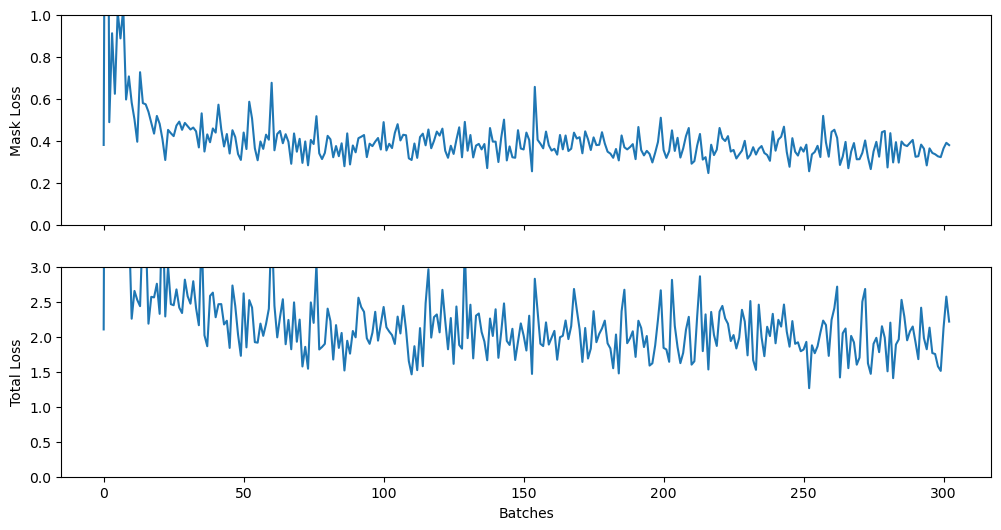

======================================== Starting epoch 2 of 18 ========================================
[Batch  50 / 303] Batch total loss:   1.551. Batch mask loss:   0.340
[Batch 100 / 303] Batch total loss:   1.775. Batch mask loss:   0.328
[Batch 150 / 303] Batch total loss:   2.036. Batch mask loss:   0.391
[Batch 200 / 303] Batch total loss:   2.437. Batch mask loss:   0.430
[Batch 250 / 303] Batch total loss:   1.958. Batch mask loss:   0.319
[Batch 300 / 303] Batch total loss:   1.440. Batch mask loss:   0.271
[Batch 303 / 303] Batch total loss:   1.387. Batch mask loss:   0.268

[Epoch  2 / 18] Epoch average mask loss :   0.355
[Epoch  2 / 18] Epoch average total loss:   1.944.
[Epoch  2 / 18] time elapsed: [399 secs]


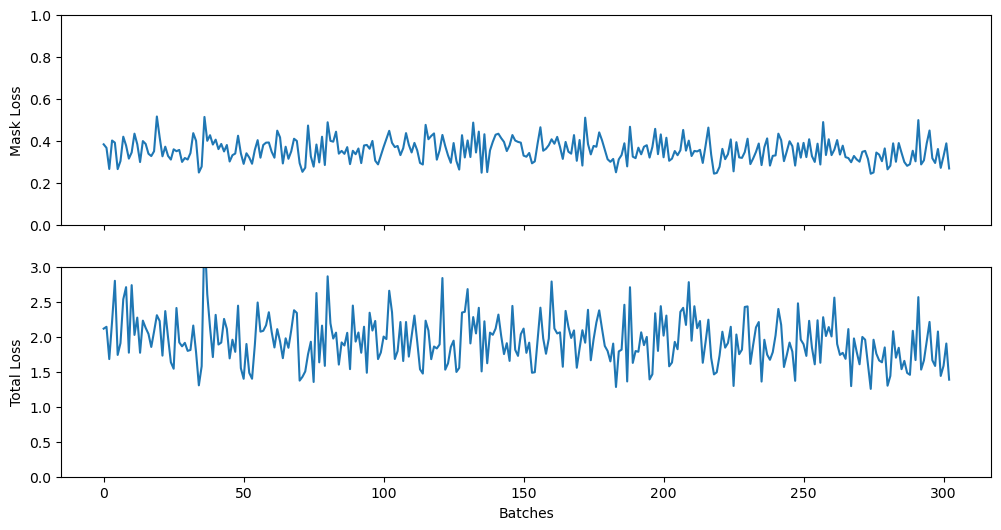

======================================== Starting epoch 3 of 18 ========================================
[Batch  50 / 303] Batch total loss:   1.248. Batch mask loss:   0.258
[Batch 100 / 303] Batch total loss:   2.127. Batch mask loss:   0.385
[Batch 150 / 303] Batch total loss:   1.397. Batch mask loss:   0.305
[Batch 200 / 303] Batch total loss:   1.671. Batch mask loss:   0.331
[Batch 250 / 303] Batch total loss:   2.537. Batch mask loss:   0.311
[Batch 300 / 303] Batch total loss:   2.094. Batch mask loss:   0.356
[Batch 303 / 303] Batch total loss:   1.774. Batch mask loss:   0.309

[Epoch  3 / 18] Epoch average mask loss :   0.347
[Epoch  3 / 18] Epoch average total loss:   1.912.
[Epoch  3 / 18] time elapsed: [397 secs]


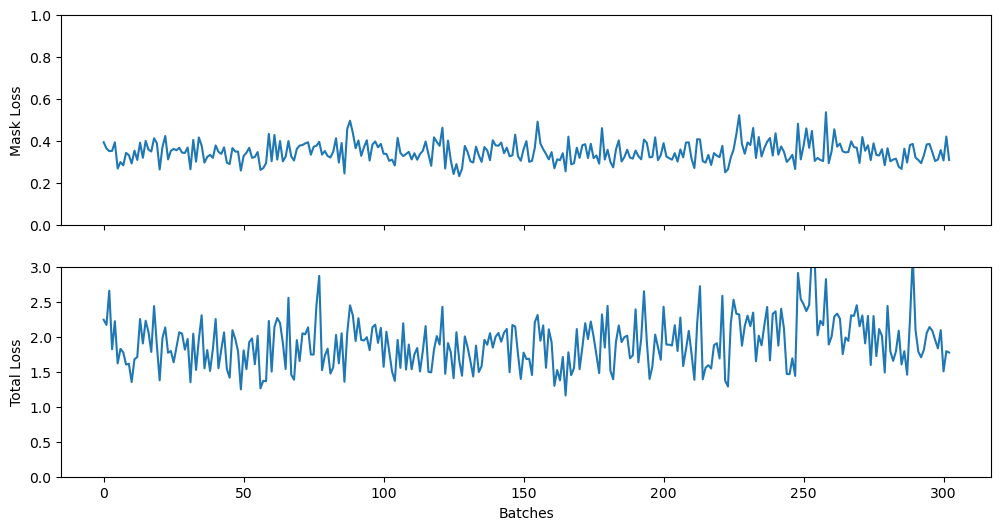

======================================== Starting epoch 4 of 18 ========================================
[Batch  50 / 303] Batch total loss:   2.352. Batch mask loss:   0.376
[Batch 100 / 303] Batch total loss:   2.456. Batch mask loss:   0.522
[Batch 150 / 303] Batch total loss:   1.695. Batch mask loss:   0.367
[Batch 200 / 303] Batch total loss:   2.512. Batch mask loss:   0.384
[Batch 250 / 303] Batch total loss:   1.838. Batch mask loss:   0.316
[Batch 300 / 303] Batch total loss:   1.674. Batch mask loss:   0.329
[Batch 303 / 303] Batch total loss:   1.798. Batch mask loss:   0.295

[Epoch  4 / 18] Epoch average mask loss :   0.370
[Epoch  4 / 18] Epoch average total loss:   2.126.
[Epoch  4 / 18] time elapsed: [395 secs]


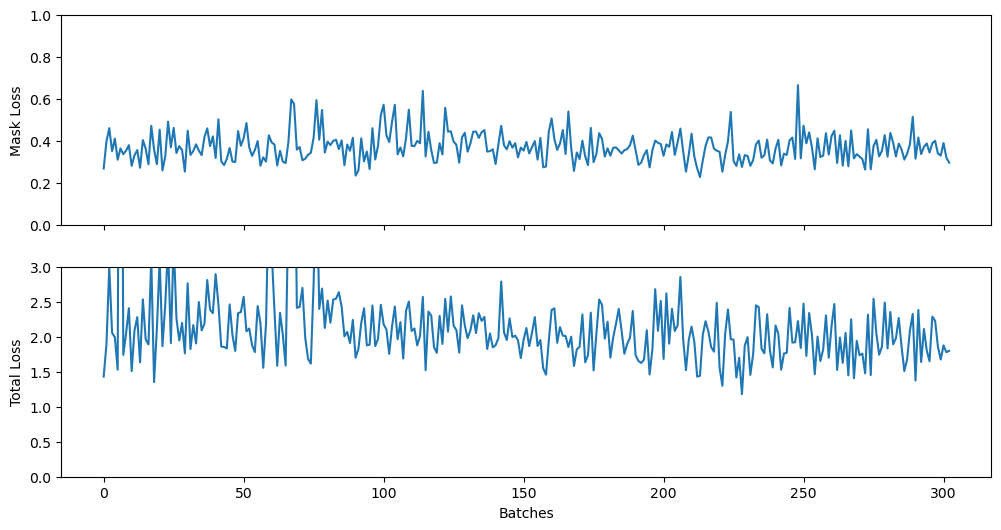

======================================== Starting epoch 5 of 18 ========================================
[Batch  50 / 303] Batch total loss:   1.447. Batch mask loss:   0.273
[Batch 100 / 303] Batch total loss:   1.872. Batch mask loss:   0.303
[Batch 150 / 303] Batch total loss:   2.024. Batch mask loss:   0.392
[Batch 200 / 303] Batch total loss:   1.643. Batch mask loss:   0.323
[Batch 250 / 303] Batch total loss:   1.725. Batch mask loss:   0.360
[Batch 300 / 303] Batch total loss:   2.089. Batch mask loss:   0.436
[Batch 303 / 303] Batch total loss:   2.063. Batch mask loss:   0.340

[Epoch  5 / 18] Epoch average mask loss :   0.344
[Epoch  5 / 18] Epoch average total loss:   1.876.
[Epoch  5 / 18] time elapsed: [396 secs]


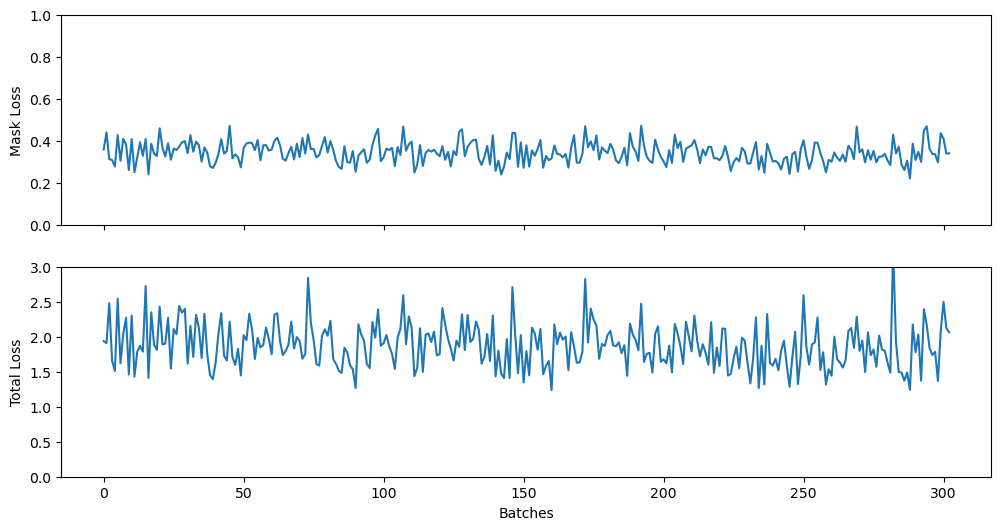

======================================== Starting epoch 6 of 18 ========================================
[Batch  50 / 303] Batch total loss:   2.392. Batch mask loss:   0.371
[Batch 100 / 303] Batch total loss:   1.512. Batch mask loss:   0.301
[Batch 150 / 303] Batch total loss:   1.631. Batch mask loss:   0.317
[Batch 200 / 303] Batch total loss:   1.427. Batch mask loss:   0.289
[Batch 250 / 303] Batch total loss:   1.513. Batch mask loss:   0.285
[Batch 300 / 303] Batch total loss:   1.552. Batch mask loss:   0.359
[Batch 303 / 303] Batch total loss:   1.248. Batch mask loss:   0.290

[Epoch  6 / 18] Epoch average mask loss :   0.341
[Epoch  6 / 18] Epoch average total loss:   1.830.
[Epoch  6 / 18] time elapsed: [396 secs]


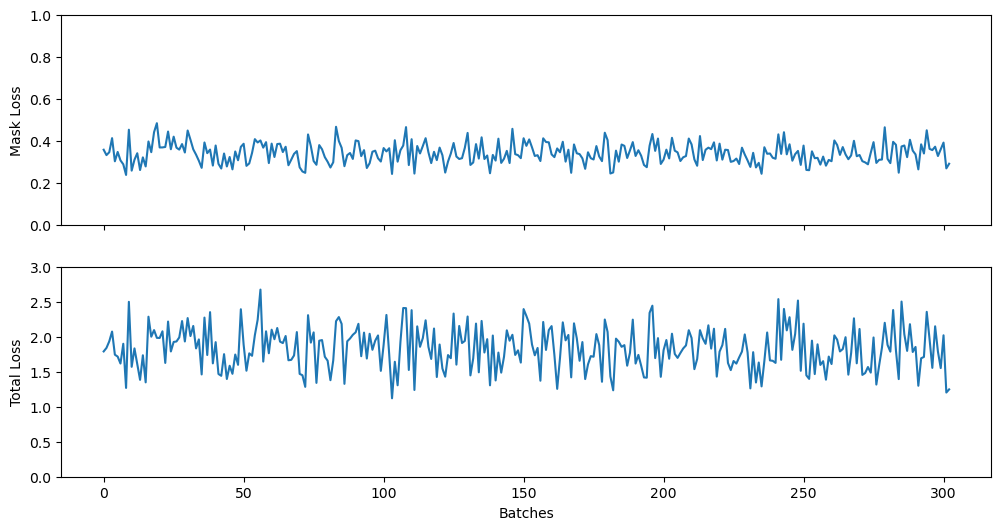

======================================== Starting epoch 7 of 18 ========================================
[Batch  50 / 303] Batch total loss:   1.551. Batch mask loss:   0.298
[Batch 100 / 303] Batch total loss:   1.726. Batch mask loss:   0.309
[Batch 150 / 303] Batch total loss:   1.411. Batch mask loss:   0.323
[Batch 200 / 303] Batch total loss:   1.717. Batch mask loss:   0.319
[Batch 250 / 303] Batch total loss:   1.346. Batch mask loss:   0.279
[Batch 300 / 303] Batch total loss:   1.918. Batch mask loss:   0.374
[Batch 303 / 303] Batch total loss:   1.769. Batch mask loss:   0.315

[Epoch  7 / 18] Epoch average mask loss :   0.334
[Epoch  7 / 18] Epoch average total loss:   1.767.
[Epoch  7 / 18] time elapsed: [397 secs]


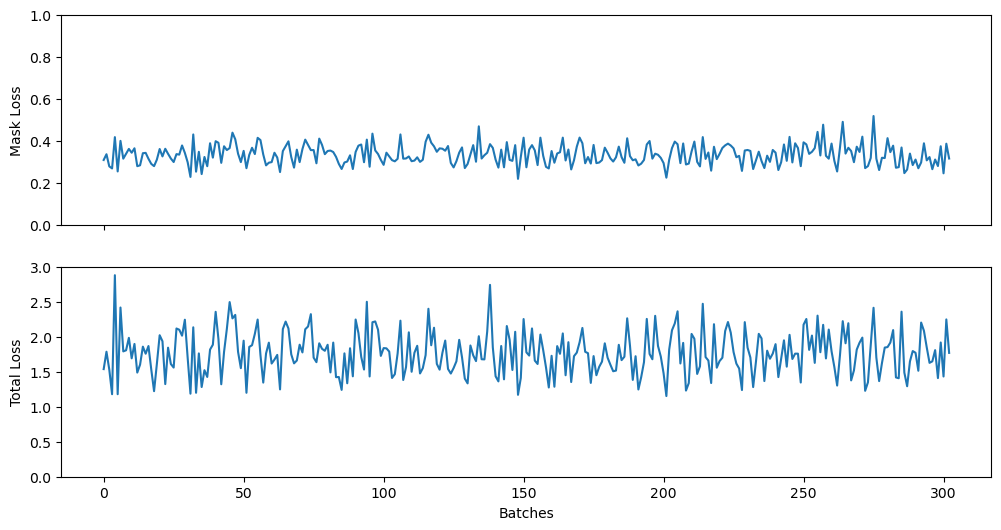

======================================== Starting epoch 8 of 18 ========================================
[Batch  50 / 303] Batch total loss:   2.901. Batch mask loss:   0.477
[Batch 100 / 303] Batch total loss:   3.222. Batch mask loss:   0.696
[Batch 150 / 303] Batch total loss:   2.837. Batch mask loss:   0.713
[Batch 200 / 303] Batch total loss:   2.525. Batch mask loss:   0.639
[Batch 250 / 303] Batch total loss:   2.466. Batch mask loss:   0.611
[Batch 300 / 303] Batch total loss:   2.603. Batch mask loss:   0.617
[Batch 303 / 303] Batch total loss:   2.136. Batch mask loss:   0.563

[Epoch  8 / 18] Epoch average mask loss :   0.658
[Epoch  8 / 18] Epoch average total loss:   3.183.
[Epoch  8 / 18] time elapsed: [393 secs]


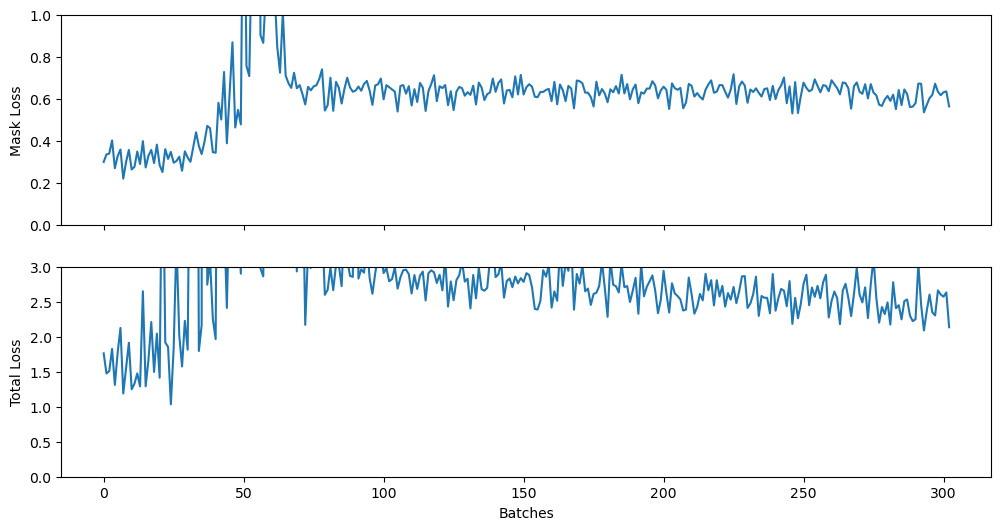

======================================== Starting epoch 9 of 18 ========================================
[Batch  50 / 303] Batch total loss:   2.346. Batch mask loss:   0.649
[Batch 100 / 303] Batch total loss:   2.341. Batch mask loss:   0.620
[Batch 150 / 303] Batch total loss:   2.625. Batch mask loss:   0.693
[Batch 200 / 303] Batch total loss:   2.182. Batch mask loss:   0.590
[Batch 250 / 303] Batch total loss:   2.551. Batch mask loss:   0.666
[Batch 300 / 303] Batch total loss:   2.467. Batch mask loss:   0.684
[Batch 303 / 303] Batch total loss:   2.960. Batch mask loss:   0.661

[Epoch  9 / 18] Epoch average mask loss :   0.702
[Epoch  9 / 18] Epoch average total loss:   2.484.
[Epoch  9 / 18] time elapsed: [388 secs]


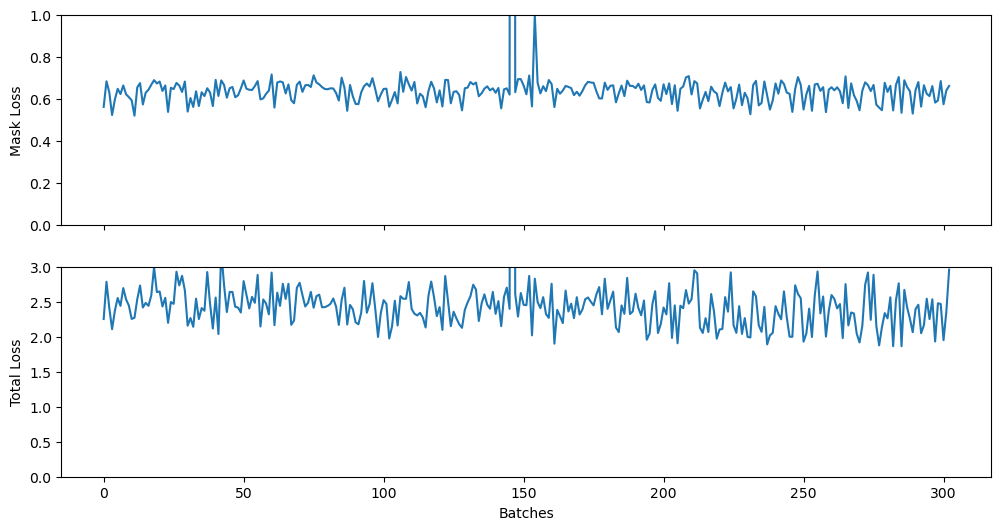

======================================== Starting epoch 10 of 18 ========================================
[Batch  50 / 303] Batch total loss:   1.760. Batch mask loss:   0.532
[Batch 100 / 303] Batch total loss:   1.879. Batch mask loss:   0.555
[Batch 150 / 303] Batch total loss:   2.382. Batch mask loss:   0.656
[Batch 200 / 303] Batch total loss:   2.019. Batch mask loss:   0.539
[Batch 250 / 303] Batch total loss:   2.607. Batch mask loss:   0.668
[Batch 300 / 303] Batch total loss:   1.716. Batch mask loss:   0.556
[Batch 303 / 303] Batch total loss:   2.014. Batch mask loss:   0.599

[Epoch 10 / 18] Epoch average mask loss :   0.633
[Epoch 10 / 18] Epoch average total loss:   2.344.
[Epoch 10 / 18] time elapsed: [386 secs]


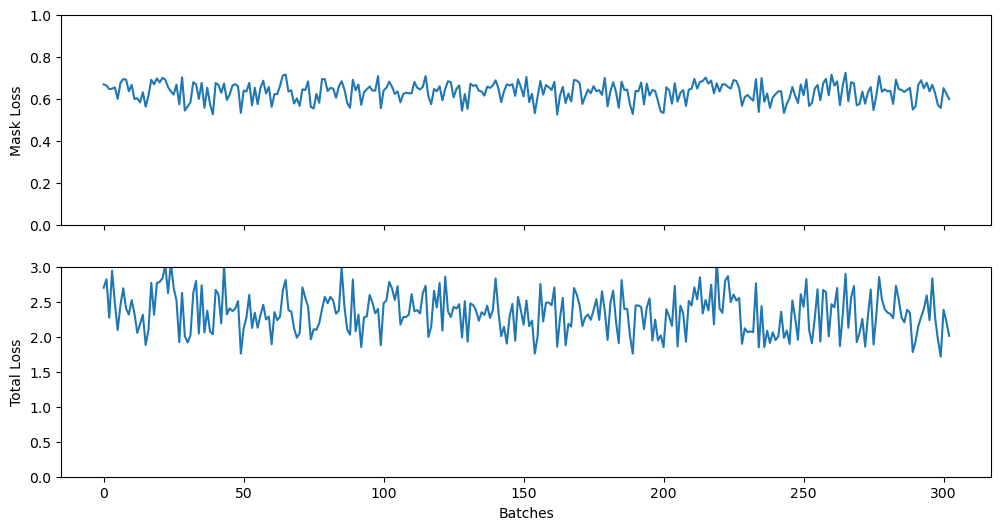

======================================== Starting epoch 11 of 18 ========================================
[Batch  50 / 303] Batch total loss:   2.733. Batch mask loss:   0.651
[Batch 100 / 303] Batch total loss:   2.566. Batch mask loss:   0.656
[Batch 150 / 303] Batch total loss:   1.937. Batch mask loss:   0.552
[Batch 200 / 303] Batch total loss:   2.702. Batch mask loss:   0.684
[Batch 250 / 303] Batch total loss:   2.259. Batch mask loss:   0.649
[Batch 300 / 303] Batch total loss:   2.481. Batch mask loss:   0.647
[Batch 303 / 303] Batch total loss:   2.300. Batch mask loss:   0.661

[Epoch 11 / 18] Epoch average mask loss :   0.633
[Epoch 11 / 18] Epoch average total loss:   2.302.
[Epoch 11 / 18] time elapsed: [388 secs]


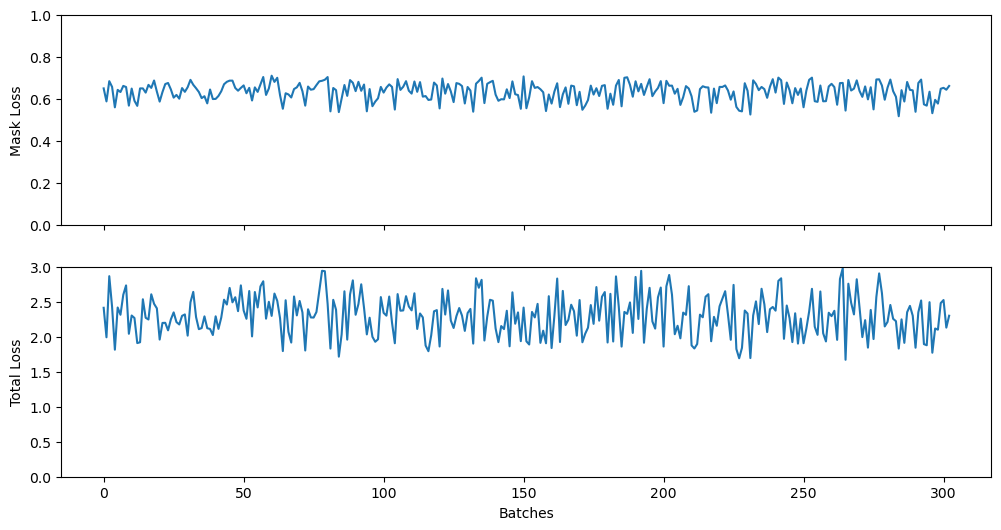

======================================== Starting epoch 12 of 18 ========================================
[Batch  50 / 303] Batch total loss:   2.378. Batch mask loss:   0.634
[Batch 100 / 303] Batch total loss:   1.859. Batch mask loss:   0.550
[Batch 150 / 303] Batch total loss:   1.601. Batch mask loss:   0.477
[Batch 200 / 303] Batch total loss:   1.885. Batch mask loss:   0.561
[Batch 250 / 303] Batch total loss:   2.270. Batch mask loss:   0.622
[Batch 300 / 303] Batch total loss:   2.390. Batch mask loss:   0.608
[Batch 303 / 303] Batch total loss:   2.476. Batch mask loss:   0.577

[Epoch 12 / 18] Epoch average mask loss :   0.632
[Epoch 12 / 18] Epoch average total loss:   2.295.
[Epoch 12 / 18] time elapsed: [387 secs]


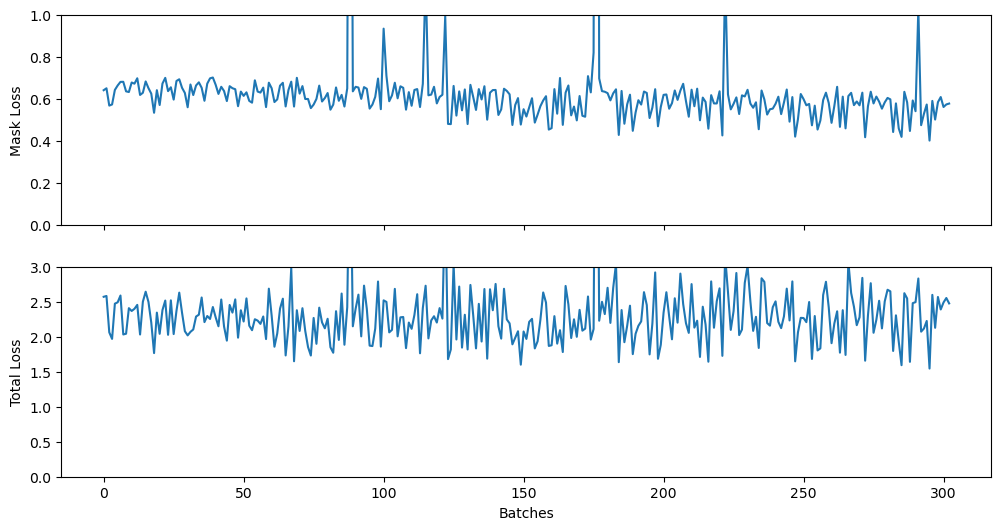

======================================== Starting epoch 13 of 18 ========================================
[Batch  50 / 303] Batch total loss:   2.174. Batch mask loss:   0.591
[Batch 100 / 303] Batch total loss:   2.309. Batch mask loss:   0.615
[Batch 150 / 303] Batch total loss:   2.450. Batch mask loss:   0.589
[Batch 200 / 303] Batch total loss:   1.796. Batch mask loss:   0.460
[Batch 250 / 303] Batch total loss:   2.343. Batch mask loss:   0.603
[Batch 300 / 303] Batch total loss:   2.306. Batch mask loss:   0.554
[Batch 303 / 303] Batch total loss:   2.353. Batch mask loss:   0.611

[Epoch 13 / 18] Epoch average mask loss :   0.574
[Epoch 13 / 18] Epoch average total loss:   2.180.
[Epoch 13 / 18] time elapsed: [388 secs]


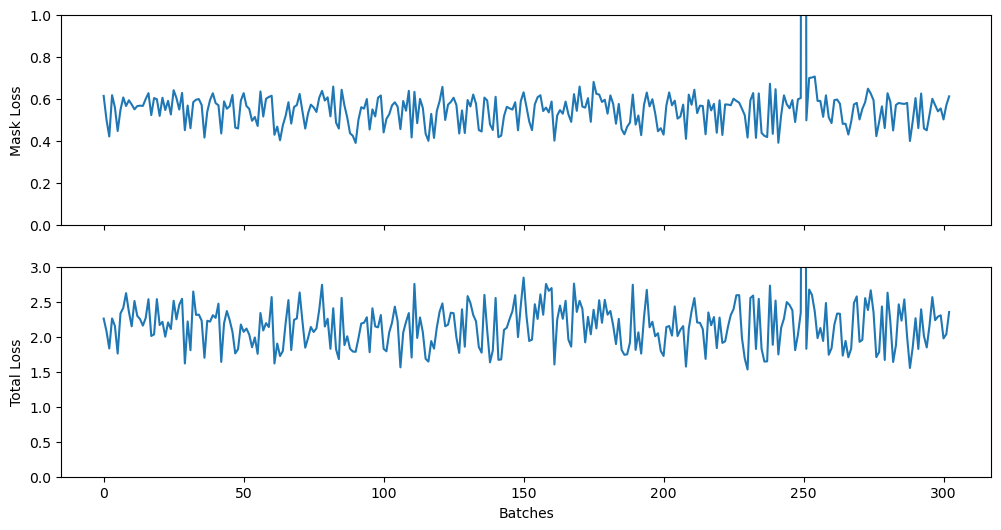

======================================== Starting epoch 14 of 18 ========================================
[Batch  50 / 303] Batch total loss:   1.664. Batch mask loss:   0.443
[Batch 100 / 303] Batch total loss:   2.621. Batch mask loss:   0.619
[Batch 150 / 303] Batch total loss:   2.061. Batch mask loss:   0.570
[Batch 200 / 303] Batch total loss:   2.195. Batch mask loss:   0.548
[Batch 250 / 303] Batch total loss:   1.557. Batch mask loss:   0.450
[Batch 300 / 303] Batch total loss:   2.343. Batch mask loss:   0.629
[Batch 303 / 303] Batch total loss:   1.735. Batch mask loss:   0.505

[Epoch 14 / 18] Epoch average mask loss :   0.562
[Epoch 14 / 18] Epoch average total loss:   2.186.
[Epoch 14 / 18] time elapsed: [388 secs]


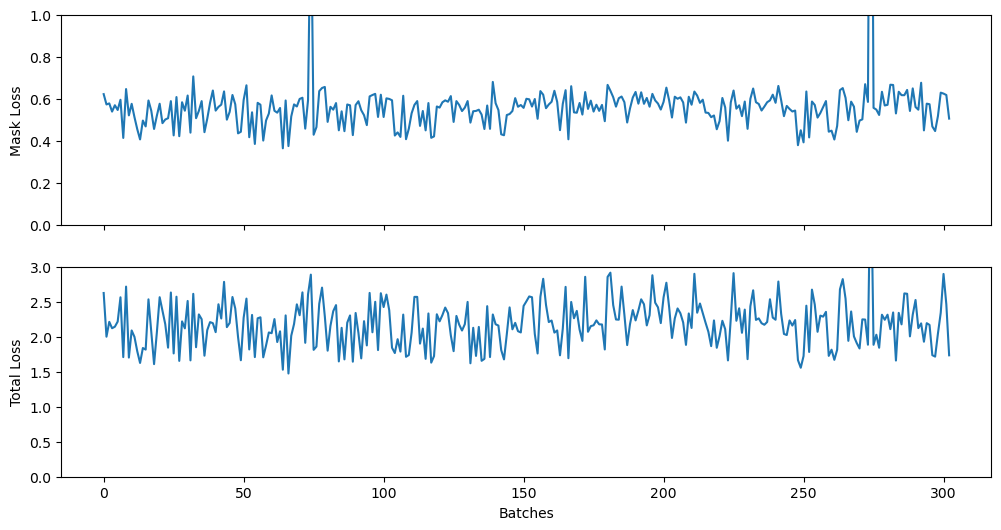

======================================== Starting epoch 15 of 18 ========================================
[Batch  50 / 303] Batch total loss:   1.871. Batch mask loss:   0.466
[Batch 100 / 303] Batch total loss:   2.299. Batch mask loss:   0.570
[Batch 150 / 303] Batch total loss:   2.432. Batch mask loss:   0.587
[Batch 200 / 303] Batch total loss:   2.064. Batch mask loss:   0.564
[Batch 250 / 303] Batch total loss:   2.498. Batch mask loss:   0.600
[Batch 300 / 303] Batch total loss:   1.912. Batch mask loss:   0.452
[Batch 303 / 303] Batch total loss:   1.997. Batch mask loss:   0.430

[Epoch 15 / 18] Epoch average mask loss :   0.543
[Epoch 15 / 18] Epoch average total loss:   2.180.
[Epoch 15 / 18] time elapsed: [388 secs]


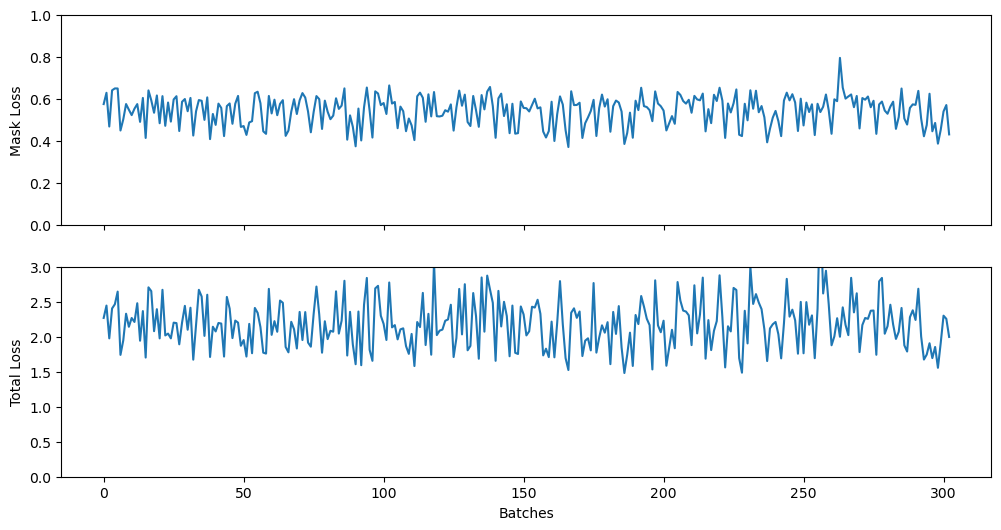

======================================== Starting epoch 16 of 18 ========================================
[Batch  50 / 303] Batch total loss:   1.697. Batch mask loss:   0.421
[Batch 100 / 303] Batch total loss:   1.768. Batch mask loss:   0.512
[Batch 150 / 303] Batch total loss:   2.010. Batch mask loss:   0.554
[Batch 200 / 303] Batch total loss:   2.302. Batch mask loss:   0.593
[Batch 250 / 303] Batch total loss:   2.071. Batch mask loss:   0.580
[Batch 300 / 303] Batch total loss:   1.697. Batch mask loss:   0.411
[Batch 303 / 303] Batch total loss:   2.126. Batch mask loss:   0.588

[Epoch 16 / 18] Epoch average mask loss :   0.592
[Epoch 16 / 18] Epoch average total loss:   2.202.
[Epoch 16 / 18] time elapsed: [389 secs]


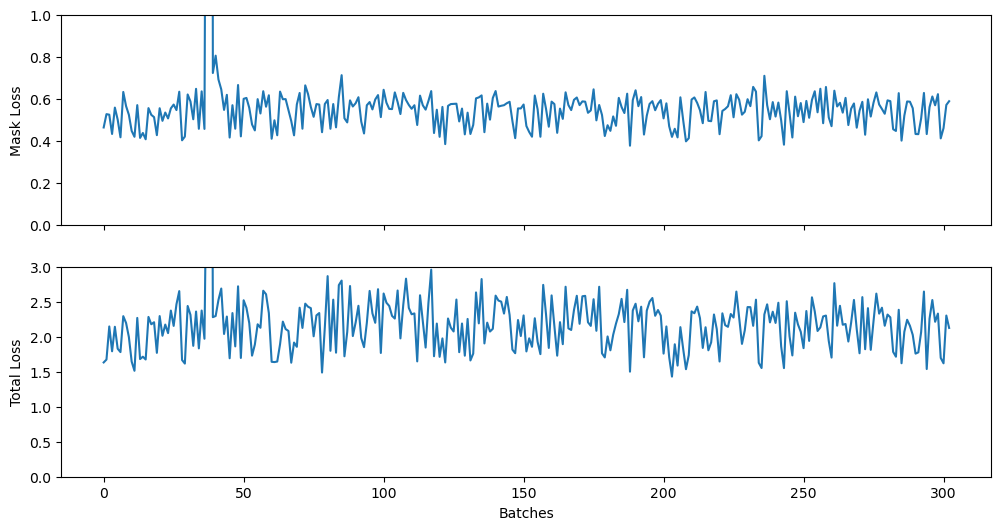

======================================== Starting epoch 17 of 18 ========================================
[Batch  50 / 303] Batch total loss:   2.176. Batch mask loss:   0.607
[Batch 100 / 303] Batch total loss:   2.258. Batch mask loss:   0.586
[Batch 150 / 303] Batch total loss:   2.367. Batch mask loss:   0.596
[Batch 200 / 303] Batch total loss:   2.297. Batch mask loss:   0.587
[Batch 250 / 303] Batch total loss:   2.345. Batch mask loss:   0.531
[Batch 300 / 303] Batch total loss:   2.364. Batch mask loss:   0.595
[Batch 303 / 303] Batch total loss:   2.415. Batch mask loss:   0.590

[Epoch 17 / 18] Epoch average mask loss :   0.539
[Epoch 17 / 18] Epoch average total loss:   2.151.
[Epoch 17 / 18] time elapsed: [390 secs]


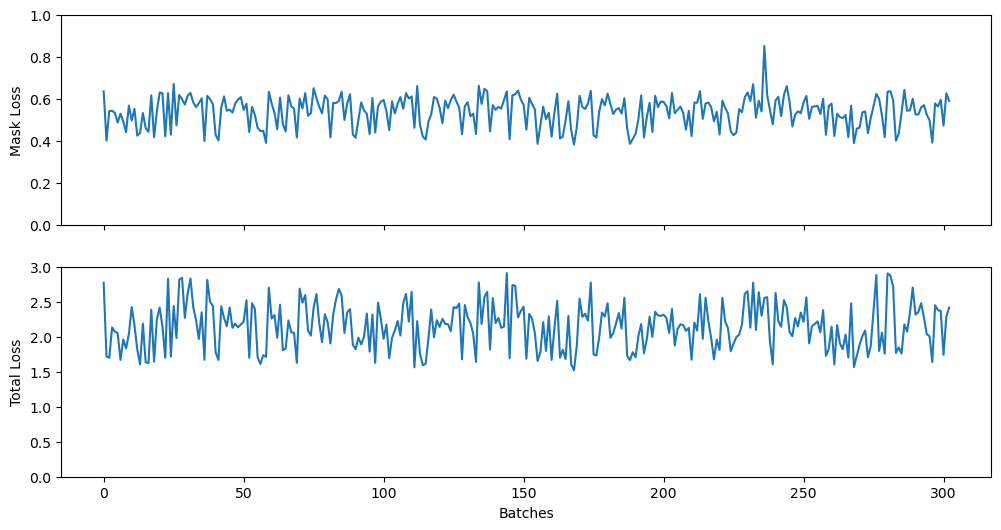

======================================== Starting epoch 18 of 18 ========================================
[Batch  50 / 303] Batch total loss:   2.205. Batch mask loss:   0.600
[Batch 100 / 303] Batch total loss:   1.658. Batch mask loss:   0.512
[Batch 150 / 303] Batch total loss:   1.742. Batch mask loss:   0.479
[Batch 200 / 303] Batch total loss:   4.440. Batch mask loss:   0.823
[Batch 250 / 303] Batch total loss:   2.243. Batch mask loss:   0.650
[Batch 300 / 303] Batch total loss:   1.896. Batch mask loss:   0.545
[Batch 303 / 303] Batch total loss:   1.962. Batch mask loss:   0.595

[Epoch 18 / 18] Epoch average mask loss :   0.717
[Epoch 18 / 18] Epoch average total loss:   2.921.
[Epoch 18 / 18] time elapsed: [390 secs]


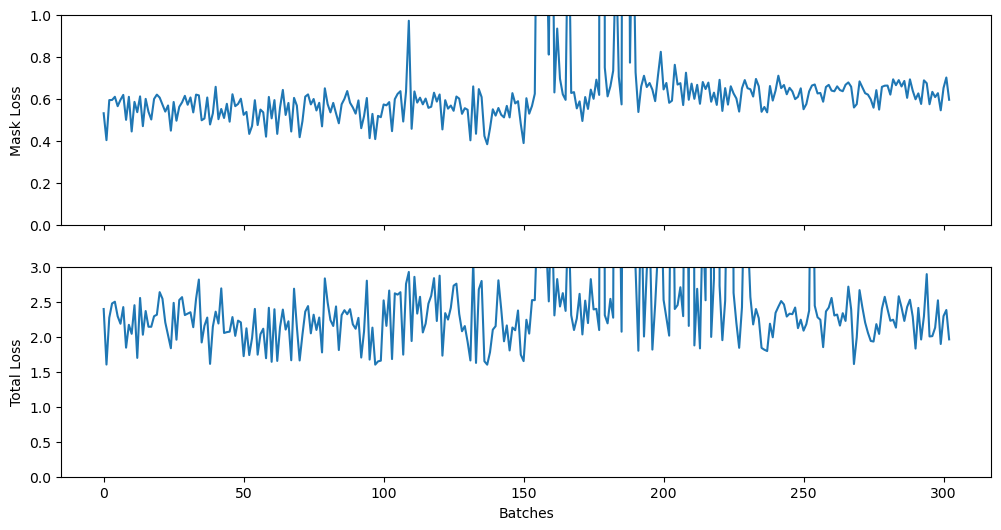

CPU times: user 1h 47min 27s, sys: 9min 54s, total: 1h 57min 22s
Wall time: 1h 57min 47s


In [46]:
%%time

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

import torch.optim as optim

# Define the parameters of the optimizer
params = model.parameters()
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# Create an Adam optimizer
optimizer = optim.Adam(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(1, EPOCHS + 1):
    print("="*40 + f" Starting epoch {epoch} of {EPOCHS} " + "="*40)
    
    time_start = time.time()
    loss_total_accum = 0.0
    loss_mask_accum = 0.0
    
    for batch_idx, (images, targets) in enumerate(dataloder_train, 1):
    
        # Predict
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss_total = sum(loss for loss in loss_dict.values())
        
        # Backprop
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
        
        # Logging
        loss_total_accum += loss_total.item()
        loss_mask = loss_dict['loss_mask'].item()
        loss_mask_accum += loss_mask
        
        loss_mask_list[epoch - 1, batch_idx - 1] = loss_mask
        loss_total_list[epoch - 1, batch_idx - 1] = loss_total.item()
        
        if (batch_idx % 50 == 0) or (batch_idx == n_batches):
            print(f"[Batch {batch_idx:3d} / {n_batches:3d}] Batch total loss: {loss_total.item():7.3f}. Batch mask loss: {loss_mask:7.3f}")
    
    if USE_SCHEDULER:
        lr_scheduler.step()
    
    # Average training loss at this epoch
    loss_total_avg = loss_total_accum / n_batches
    loss_mask_avg = loss_mask_accum / n_batches
    
    # Time consuming of this training epoch
    elapsed = time.time() - time_start
    
    
    torch.save(model.state_dict(), f"./MyModelSave/pytorch_mrcnn-epoch{epoch}.bin")
    
    print()
    prefix = f"[Epoch {epoch:2d} / {EPOCHS:2d}]"
    print(f"{prefix} Epoch average mask loss : {loss_mask_avg:7.3f}")
    print(f"{prefix} Epoch average total loss: {loss_total_avg:7.3f}.")
    print(f"{prefix} time elapsed: [{elapsed:.0f} secs]")
    
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax1.set_ylim(0, 1)
    ax1.plot(loss_mask_list[epoch-1])
    ax1.set_ylabel("Mask Loss")
    
    ax2.set_ylim(0, 3)
    ax2.plot(loss_total_list[epoch-1])
    ax2.set_ylabel("Total Loss")
    ax2.set_xlabel("Batches")
    plt.show()

In [47]:
class CellTestDataset(Dataset):
    def __init__(self, test_path, transforms=None):
        self.transforms = transforms
        self.image_dir = test_path
        self.image_ids = [file_name[:-4] for file_name in os.listdir(self.image_dir)]
        
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + ".png")
        image = Image.open(image_path).convert("RGB")    # 实现将单通道的灰度图像转换为三通道的
        
        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)
        
        return {'image': image, 'image_id': image_id}
    
    
    def __len__(self):
        return len(self.image_ids)
dataset_test = CellTestDataset(TEST_PATH, transforms=transforms(train=False))
# len(dataset_test)   # 3
dataset_test[0]

{'image': tensor([[[0.5020, 0.5020, 0.4980,  ..., 0.4980, 0.4941, 0.4902],
          [0.5020, 0.5020, 0.4941,  ..., 0.5020, 0.5020, 0.5020],
          [0.5098, 0.5098, 0.5020,  ..., 0.5137, 0.5020, 0.5137],
          ...,
          [0.4980, 0.4980, 0.4980,  ..., 0.5333, 0.5216, 0.5176],
          [0.5098, 0.5098, 0.5098,  ..., 0.5373, 0.5451, 0.5373],
          [0.4941, 0.5059, 0.5020,  ..., 0.5686, 0.5569, 0.5490]],
 
         [[0.5020, 0.5020, 0.4980,  ..., 0.4980, 0.4941, 0.4902],
          [0.5020, 0.5020, 0.4941,  ..., 0.5020, 0.5020, 0.5020],
          [0.5098, 0.5098, 0.5020,  ..., 0.5137, 0.5020, 0.5137],
          ...,
          [0.4980, 0.4980, 0.4980,  ..., 0.5333, 0.5216, 0.5176],
          [0.5098, 0.5098, 0.5098,  ..., 0.5373, 0.5451, 0.5373],
          [0.4941, 0.5059, 0.5020,  ..., 0.5686, 0.5569, 0.5490]],
 
         [[0.5020, 0.5020, 0.4980,  ..., 0.4980, 0.4941, 0.4902],
          [0.5020, 0.5020, 0.4941,  ..., 0.5020, 0.5020, 0.5020],
          [0.5098, 0.5098, 0.50

In [48]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    
    return ' '.join(map(str, run_lengths))

In [49]:
def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    
    return mask

In [59]:
model.load_state_dict(torch.load('/kaggle/working/MyModelSave/pytorch_mrcnn-epoch7.bin', map_location=torch.device('cuda')))

<All keys matched successfully>

In [66]:
len(sample['image'])

3

# Test SET

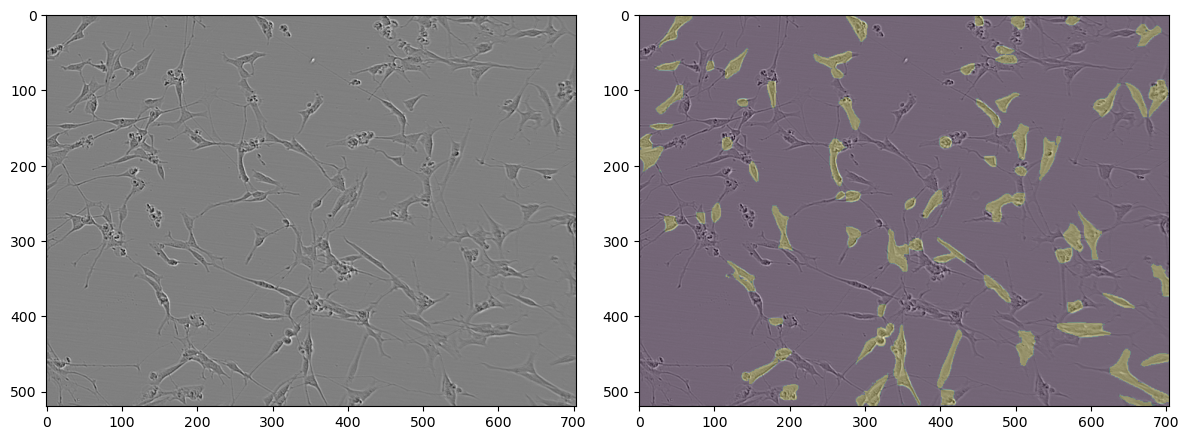

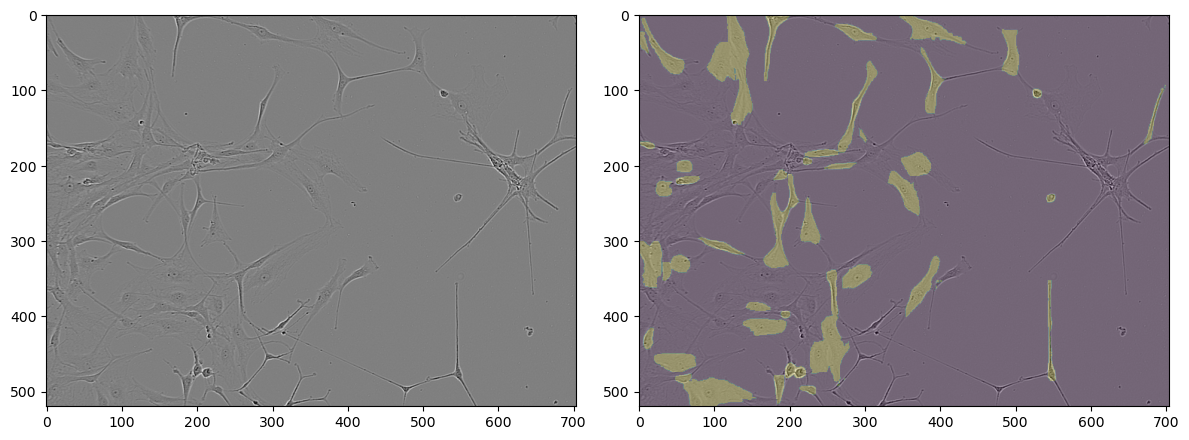

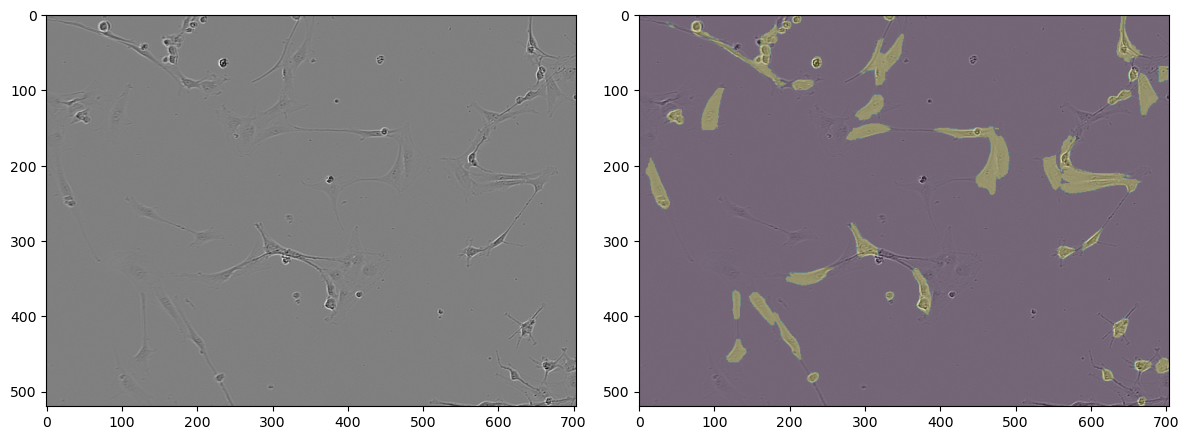

In [81]:
model.eval();

submission = []
for sample in dataset_test:
    img = sample['image']
    image_id = sample['image_id']
    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]
    
    previous_masks = []
    for i, mask in enumerate(result["masks"]):
        
        # Filter-out low-scoring results. Not tried yet.
        score = result["scores"][i].cpu().item()
        if score < MIN_SCORE:                   # MIN_SCORE = 0.59
            continue
        
        mask = mask.cpu().numpy()
        # Keep only highly likely pixels
        binary_mask = mask > MASK_THRESHOLD    # MASK_THRESHOLD = 0.5
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        previous_masks.append(binary_mask)
        rle = rle_encoding(binary_mask)
        submission.append((image_id, rle))
    
    plt.figure(figsize=(12,12))
    ax1 = plt.subplot(121)
    ax1.imshow(img.cpu().numpy().transpose((1,2,0)))
    all_preds_masks = np.zeros((HEIGHT, WIDTH))
    for mask in result['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > MASK_THRESHOLD)
    ax2 = plt.subplot(122)
    ax2.imshow(img.cpu().numpy().transpose((1,2,0)))
    ax2.imshow(all_preds_masks, alpha=0.2)
    plt.tight_layout()
    plt.show()
    
    
    # Add empty prediction if no RLE was generated for this image
    all_images_ids = [image_id for image_id, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ""))

# Train SET

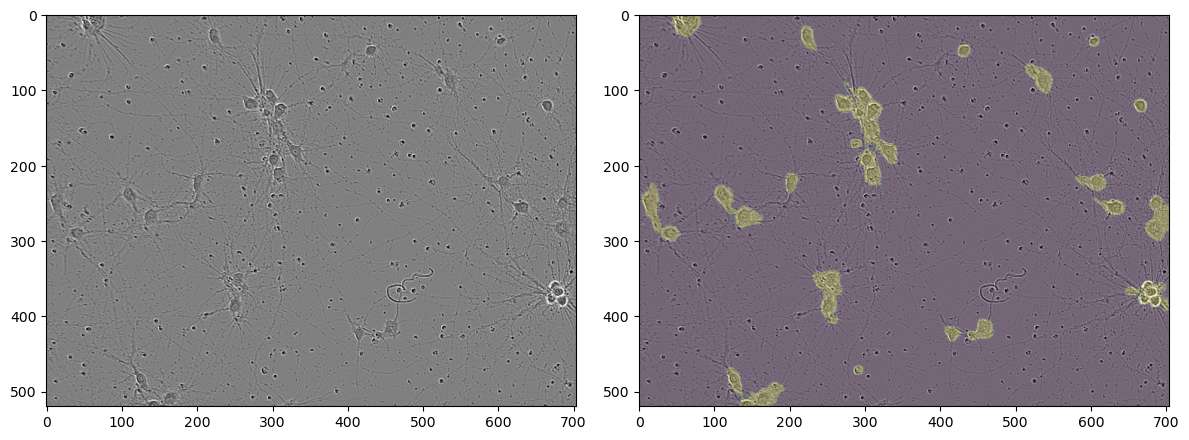

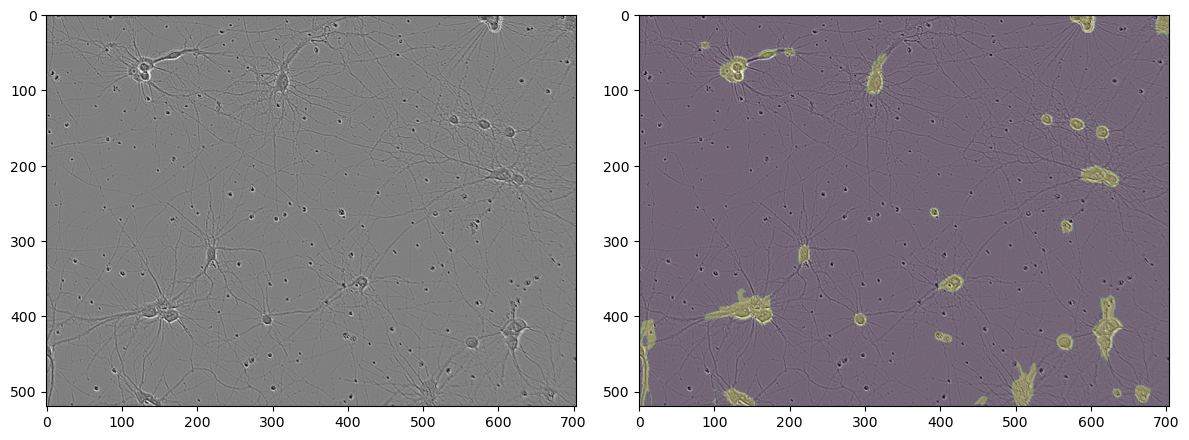

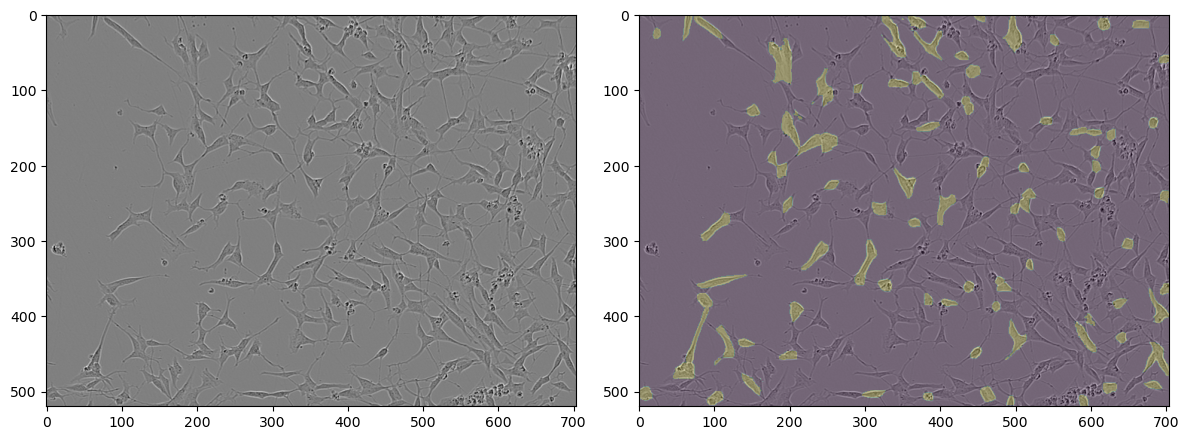

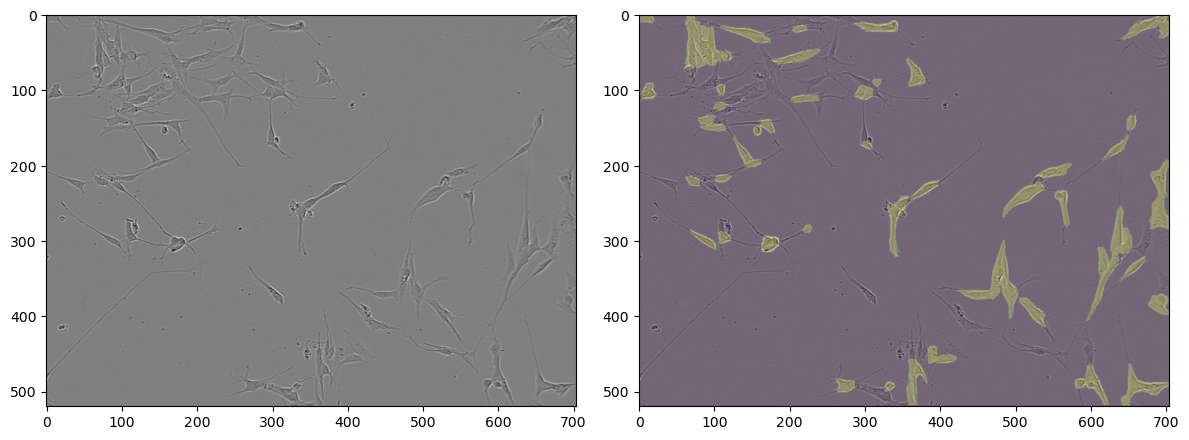

In [85]:
model.eval();

submission = []
ids_list = ['01ae5a43a2ab', '0323e81d23d9', '042dc0e561a4', '04cd81dfb245']
for i in range(len(ids_list)):
    image_id = ids_list[i]
    img = cv2.imread(TRAIN_PATH + image_id + ".png")         # BGR mode
    
    
    
    img = torch.tensor(img).permute(2, 0, 1).float() / 255.0
    #img = sample['image']
    #image_id = sample['image_id']
    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]
    
    previous_masks = []
    for i, mask in enumerate(result["masks"]):
        
        # Filter-out low-scoring results. Not tried yet.
        score = result["scores"][i].cpu().item()
        if score < MIN_SCORE:                   # MIN_SCORE = 0.59
            continue
        
        mask = mask.cpu().numpy()
        # Keep only highly likely pixels
        binary_mask = mask > MASK_THRESHOLD    # MASK_THRESHOLD = 0.5
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        previous_masks.append(binary_mask)
        rle = rle_encoding(binary_mask)
        submission.append((image_id, rle))
    
    plt.figure(figsize=(12,12))
    ax1 = plt.subplot(121)
    ax1.imshow(img.cpu().numpy().transpose((1,2,0)))
    all_preds_masks = np.zeros((HEIGHT, WIDTH))
    for mask in result['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > MASK_THRESHOLD)
    ax2 = plt.subplot(122)
    ax2.imshow(img.cpu().numpy().transpose((1,2,0)))
    ax2.imshow(all_preds_masks, alpha=0.2)
    plt.tight_layout()
    plt.show()
    
    
    # Add empty prediction if no RLE was generated for this image
    all_images_ids = [image_id for image_id, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ""))

In [61]:
df_sub = pd.DataFrame(submission, columns=['id', 'predicted'])
df_sub.to_csv("/kaggle/working/My_MRCNN.csv", index=False)
df_sub.head()

id                                          predicted
0  7ae19de7bc2a  1151 8 1855 9 2559 10 3263 11 3967 11 4671 12 ...
1  7ae19de7bc2a  45103 4 45795 18 46495 22 47197 24 47899 26 48...
2  7ae19de7bc2a  165014 10 165717 15 166420 18 167124 19 167828...
3  d8bfd1dafdc4  328982 4 329682 10 330385 12 331089 13 331792 ...
4  d48ec7815252  6410 9 7113 11 7816 13 8519 14 9223 14 9927 14...

In [63]:
# SAVE MODEL WEIGHTS
!zip -r MaskRCNNweights.zip /kaggle/working/MyModelSave
from IPython.display import FileLink
FileLink(r'MaskRCNNweights.zip')

  adding: kaggle/working/MyModelSave/ (stored 0%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch9.bin (deflated 5%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch16.bin (deflated 4%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch18.bin (deflated 5%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch8.bin (deflated 6%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch14.bin (deflated 5%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch2.bin (deflated 7%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch17.bin (deflated 4%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch4.bin (deflated 6%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch13.bin (deflated 5%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch6.bin (deflated 6%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch3.bin (deflated 6%)
  adding: kaggle/working/MyModelSave/pytorch_mrcnn-epoch5.bin (deflated 6%)
  adding: kaggle/working/MyModelS

/kaggle/working/MaskRCNNweights.zip